# Step 1: Data Preparation & Mapping

In [1]:
import json
import os
from collections import defaultdict
import pandas as pd

# File paths
ANNOTATION_FILES = {
    'Expert_A': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\alexa_annotations.json',
    'Expert_K': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\katrin_annotations.json',
    'Expert_L': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\luisa_annotations.json',
    'Expert_M': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\martin_annotations.json'
}

def analyze_annotation_structure():
    """Analyze the structure and content of each expert's annotation file"""
    
    total_annotations = 0
    expert_stats = {}
    
    for expert, filepath in ANNOTATION_FILES.items():
        print(f"\n{'='*50}")
        print(f"ANALYZING {expert.upper()} ANNOTATIONS")
        print(f"{'='*50}")
        
        try:
            # Load JSON file
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            print(f"✓ File loaded successfully")
            print(f"Data type: {type(data)}")
            print(f"Number of records: {len(data)}")
            
            # Initialize counters for this expert
            expert_stats[expert] = {
                'total_records': len(data),
                'annotated_records': 0,
                'iaa_images': 0,
                'non_iaa_images': 0,
                'txt_img_align_scores': [],
                'annotation_fields': set(),
                'original_filenames': []
            }
            
            # Analyze each record
            annotated_count = 0
            iaa_count = 0
            
            for i, record in enumerate(data):
                # Check if record has annotations
                if 'annotations' in record and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]  # Take first annotation
                    
                    if 'result' in annotation and len(annotation['result']) > 0:
                        annotated_count += 1
                        
                        # Extract original filename
                        if 'data' in record and 'original_filename' in record['data']:
                            filename = record['data']['original_filename']
                            expert_stats[expert]['original_filenames'].append(filename)
                            
                            # Check if it's an IAA image
                            if '_IAA' in filename:
                                iaa_count += 1
                        
                        # Analyze annotation fields
                        for result_item in annotation['result']:
                            if 'from_name' in result_item:
                                field_name = result_item['from_name']
                                expert_stats[expert]['annotation_fields'].add(field_name)
                                
                                # Extract txt_img_align scores specifically
                                if field_name == 'txt_img_align' and 'value' in result_item:
                                    if 'number' in result_item['value']:
                                        score = result_item['value']['number']
                                        expert_stats[expert]['txt_img_align_scores'].append(score)
            
            # Update stats
            expert_stats[expert]['annotated_records'] = annotated_count
            expert_stats[expert]['iaa_images'] = iaa_count
            expert_stats[expert]['non_iaa_images'] = annotated_count - iaa_count
            
            # Print summary for this expert
            print(f"Records with annotations: {annotated_count}")
            print(f"IAA images: {iaa_count}")
            print(f"Non-IAA images: {annotated_count - iaa_count}")
            print(f"Text-Image Alignment scores found: {len(expert_stats[expert]['txt_img_align_scores'])}")
            print(f"Annotation fields found: {len(expert_stats[expert]['annotation_fields'])}")
            print(f"Fields: {sorted(expert_stats[expert]['annotation_fields'])}")
            
            # Show first few filenames as examples
            if expert_stats[expert]['original_filenames']:
                print(f"\nFirst 3 original filenames:")
                for filename in expert_stats[expert]['original_filenames'][:3]:
                    print(f"  - {filename}")
            
            # Show txt_img_align score distribution
            if expert_stats[expert]['txt_img_align_scores']:
                scores = expert_stats[expert]['txt_img_align_scores']
                print(f"\nText-Image Alignment Score Distribution:")
                print(f"  Min: {min(scores)}")
                print(f"  Max: {max(scores)}")
                print(f"  Mean: {sum(scores)/len(scores):.2f}")
                print(f"  Count: {len(scores)}")
            
            total_annotations += annotated_count
            
        except FileNotFoundError:
            print(f"✗ File not found: {filepath}")
            expert_stats[expert] = {'error': 'File not found'}
        except json.JSONDecodeError as e:
            print(f"✗ JSON decode error: {e}")
            expert_stats[expert] = {'error': f'JSON decode error: {e}'}
        except Exception as e:
            print(f"✗ Unexpected error: {e}")
            expert_stats[expert] = {'error': f'Unexpected error: {e}'}
    
    # Print overall summary
    print(f"\n{'='*50}")
    print("OVERALL SUMMARY")
    print(f"{'='*50}")
    
    summary_data = []
    total_valid_annotations = 0
    total_iaa = 0
    
    for expert, stats in expert_stats.items():
        if 'error' not in stats:
            summary_data.append({
                'Expert': expert,
                'Total Records': stats['total_records'],
                'Annotated Records': stats['annotated_records'],
                'IAA Images': stats['iaa_images'],
                'Non-IAA Images': stats['non_iaa_images'],
                'TXT-IMG Align Scores': len(stats['txt_img_align_scores'])
            })
            total_valid_annotations += stats['annotated_records']
            total_iaa += stats['iaa_images']
        else:
            summary_data.append({
                'Expert': expert,
                'Error': stats['error']
            })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary Table:")
    print(summary_df.to_string(index=False))
    
    print(f"\nGrand Total:")
    print(f"Total valid annotations across all experts: {total_valid_annotations}")
    print(f"Total IAA images across all experts: {total_iaa}")
    
    return expert_stats, summary_df

def check_file_existence():
    """Check if all required files exist"""
    print("Checking file existence...")
    
    for expert, filepath in ANNOTATION_FILES.items():
        if os.path.exists(filepath):
            file_size = os.path.getsize(filepath)
            print(f"✓ {expert}: {filepath} ({file_size:,} bytes)")
        else:
            print(f"✗ {expert}: {filepath} - FILE NOT FOUND")

def analyze_sample_annotation():
    """Analyze a sample annotation structure in detail"""
    print(f"\n{'='*50}")
    print("DETAILED SAMPLE ANNOTATION ANALYSIS")
    print(f"{'='*50}")
    
    # Find the first available file
    for expert, filepath in ANNOTATION_FILES.items():
        if os.path.exists(filepath):
            print(f"\nAnalyzing sample from {expert}...")
            
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if len(data) > 0:
                # Find first record with annotations
                sample_record = None
                for record in data:
                    if 'annotations' in record and len(record['annotations']) > 0:
                        annotation = record['annotations'][0]
                        if 'result' in annotation and len(annotation['result']) > 0:
                            sample_record = record
                            break
                
                if sample_record:
                    print(f"\n--- SAMPLE RECORD STRUCTURE ---")
                    print(f"Record keys: {list(sample_record.keys())}")
                    
                    # Data field
                    if 'data' in sample_record:
                        print(f"\nData field keys: {list(sample_record['data'].keys())}")
                        for key, value in sample_record['data'].items():
                            if isinstance(value, str) and len(value) > 100:
                                print(f"  {key}: {value[:100]}...")
                            else:
                                print(f"  {key}: {value}")
                    
                    # Annotation structure
                    annotation = sample_record['annotations'][0]
                    print(f"\nAnnotation keys: {list(annotation.keys())}")
                    
                    # Result structure
                    if 'result' in annotation:
                        print(f"\nResult items ({len(annotation['result'])}):")
                        for i, item in enumerate(annotation['result']):
                            print(f"  Item {i+1}: {item.get('from_name', 'unknown')} = {item.get('value', 'no value')}")
                
                break
            
            return
    
    print("No valid annotation files found!")

if __name__ == "__main__":
    # Run the analysis
    check_file_existence()
    expert_stats, summary_df = analyze_annotation_structure()
    analyze_sample_annotation()

Checking file existence...
✓ Expert_A: C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\alexa_annotations.json (516,714,741 bytes)
✓ Expert_K: C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\katrin_annotations.json (534,606,387 bytes)
✓ Expert_L: C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\luisa_annotations.json (438,514,869 bytes)
✓ Expert_M: C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\martin_annotations.json (572,472,788 bytes)

ANALYZING EXPERT_A ANNOTATIONS
✓ File loaded successfully
Data type: <class 'list'>
Number of records: 250
Records with annotations: 250
IAA images: 71
Non-IAA images: 179
Text-Image Alignment scores found: 250
Annotation fields found: 11
Fields: ['concerns', 'ethics', 'image_style', 'img_quality', 'img_simplicity', 'no_text', 'notes', 'txt_img_align', 'txt_quality', 'txt_simplicity', 'well_separated_ob

In [7]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path

# File paths
ANNOTATION_FILES = {
    'Expert_A': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\alexa_annotations.json',
    'Expert_K': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\katrin_annotations.json',
    'Expert_L': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\luisa_annotations.json',
    'Expert_M': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\martin_annotations.json'
}

IMAGE_DIR = r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\phase3_label_studio\2000_set_shuffled'
MAPPING_FILE = r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files\renamed_images_mapping.csv'

def step1_load_mapping_data():
    """Step 1A: Load and examine the mapping file"""
    print("="*60)
    print("STEP 1A: LOADING MAPPING DATA")
    print("="*60)
    
    try:
        mapping_df = pd.read_csv(MAPPING_FILE)
        print(f"✓ Mapping file loaded successfully")
        print(f"📊 Total mapping entries: {len(mapping_df)}")
        print(f"📋 Columns: {list(mapping_df.columns)}")
        
        # Show sample mappings
        print(f"\n📄 First 5 mapping entries:")
        print(mapping_df.head().to_string(index=False))
        
        # Check for any duplicates
        duplicates = mapping_df['new_filename'].duplicated().sum()
        print(f"\n🔍 Duplicate new_filenames: {duplicates}")
        
        return mapping_df
        
    except Exception as e:
        print(f"✗ Error loading mapping file: {e}")
        return None

def step1_extract_annotation_filenames():
    """Step 1B: Extract all filenames from annotation JSON files"""
    print("\n" + "="*60)
    print("STEP 1B: EXTRACTING ANNOTATION FILENAMES")
    print("="*60)
    
    all_annotation_data = []
    
    for expert, filepath in ANNOTATION_FILES.items():
        print(f"\n--- Processing {expert} ---")
        
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            expert_filenames = []
            expert_scores = []
            expert_texts = []
            
            for record in data:
                if 'annotations' in record and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]
                    
                    if 'result' in annotation and 'data' in record:
                        # Extract filename and text
                        label_studio_filename = record['data'].get('original_filename', '')
                        simplified_text = record['data'].get('simplified_text', '')
                        
                        # Extract txt_img_align score
                        txt_img_align_score = None
                        for item in annotation['result']:
                            if item.get('from_name') == 'txt_img_align':
                                if 'value' in item and 'number' in item['value']:
                                    txt_img_align_score = item['value']['number']
                                    break
                        
                        if txt_img_align_score is not None and label_studio_filename and simplified_text:
                            expert_filenames.append(label_studio_filename)
                            expert_scores.append(txt_img_align_score)
                            expert_texts.append(simplified_text)
                            
                            all_annotation_data.append({
                                'expert': expert,
                                'label_studio_filename': label_studio_filename,
                                'simplified_text': simplified_text,
                                'human_score': txt_img_align_score,
                                'is_iaa': '_IAA' in label_studio_filename
                            })
            
            print(f"  ✓ Extracted {len(expert_filenames)} valid annotations")
            print(f"  📁 IAA files: {sum(1 for f in expert_filenames if '_IAA' in f)}")
            print(f"  📁 Regular files: {sum(1 for f in expert_filenames if '_IAA' not in f)}")
            print(f"  📄 Example filenames: {expert_filenames[:3]}")
            
        except Exception as e:
            print(f"  ✗ Error processing {expert}: {e}")
    
    annotations_df = pd.DataFrame(all_annotation_data)
    
    print(f"\n📊 TOTAL EXTRACTION SUMMARY:")
    print(f"Total annotations extracted: {len(annotations_df)}")
    print(f"Unique filenames: {annotations_df['label_studio_filename'].nunique()}")
    print(f"IAA annotations: {annotations_df['is_iaa'].sum()}")
    print(f"Regular annotations: {(~annotations_df['is_iaa']).sum()}")
    
    return annotations_df

def step1_create_filename_mapping(mapping_df, annotations_df):
    """Step 1C: Create filename mapping and handle IAA files"""
    print("\n" + "="*60)
    print("STEP 1C: CREATING FILENAME MAPPING")
    print("="*60)
    
    # Get unique filenames from annotations
    unique_annotation_filenames = set(annotations_df['label_studio_filename'].unique())
    
    print(f"Unique annotation filenames to map: {len(unique_annotation_filenames)}")
    
    # Separate IAA and regular files
    iaa_filenames = {f for f in unique_annotation_filenames if '_IAA' in f}
    regular_filenames = {f for f in unique_annotation_filenames if '_IAA' not in f}
    
    print(f"IAA filenames to map: {len(iaa_filenames)}")
    print(f"Regular filenames to map: {len(regular_filenames)}")
    
    # Create mapping for regular files
    mapping_dict = dict(zip(mapping_df['new_filename'], mapping_df['original_filename']))
    style_dict = dict(zip(mapping_df['new_filename'], mapping_df['style']))
    
    print(f"\nMapping dictionary created with {len(mapping_dict)} entries")
    
    # Check regular filename mapping
    print(f"\n🔍 CHECKING REGULAR FILENAME MAPPING:")
    regular_found = 0
    regular_missing = []
    
    for filename in list(regular_filenames)[:10]:  # Check first 10
        if filename in mapping_dict:
            print(f"  ✓ {filename} → {mapping_dict[filename]}")
            regular_found += 1
        else:
            print(f"  ✗ {filename} → NOT FOUND")
            regular_missing.append(filename)
    
    print(f"Regular files sample check: {regular_found}/{min(10, len(regular_filenames))} found")
    
    # Handle IAA filename mapping
    print(f"\n🔍 HANDLING IAA FILENAME MAPPING:")
    print("IAA files in annotations:", list(iaa_filenames)[:5])
    
    # Strategy: Extract 4-digit number and add .png to find mapping
    iaa_mapping_dict = {}
    iaa_found = 0
    iaa_missing = []
    
    for iaa_filename in iaa_filenames:  # Process ALL IAA files, not just first 10
        # Extract 4-digit number from filename like "0008_IAA.png"
        import re
        match = re.search(r'(\d{4})', iaa_filename)
        
        if match:
            number = match.group(1)
            base_filename = f"{number}.png"
            
            if base_filename in mapping_dict:
                iaa_mapping_dict[iaa_filename] = mapping_dict[base_filename]
                iaa_found += 1
                # Only print first 10 for readability
                if iaa_found <= 10:
                    print(f"  ✓ {iaa_filename} → {number} → {base_filename} → {mapping_dict[base_filename]}")
            else:
                iaa_missing.append(iaa_filename)
                # Only print first 10 missing for readability
                if len(iaa_missing) <= 10:
                    print(f"  ✗ {iaa_filename} → {number} → {base_filename} → NOT FOUND")
        else:
            iaa_missing.append(iaa_filename)
            if len(iaa_missing) <= 10:
                print(f"  ✗ {iaa_filename} → Could not extract 4-digit number")
    
    print(f"IAA files sample check: {iaa_found}/{len(iaa_filenames)} found")
    
    if len(iaa_missing) > 0:
        print(f"  ⚠️  {len(iaa_missing)} IAA files could not be mapped")
        if len(iaa_missing) <= 10:
            print(f"  Missing: {iaa_missing}")
        else:
            print(f"  First 10 missing: {iaa_missing[:10]}")
    
    # Combine mappings
    complete_mapping_dict = {**mapping_dict, **iaa_mapping_dict}
    
    print(f"\n📊 MAPPING SUMMARY:")
    print(f"Total mappings available: {len(complete_mapping_dict)}")
    print(f"Regular file mappings: {len(mapping_dict)}")
    print(f"IAA file mappings: {len(iaa_mapping_dict)}")
    
    return complete_mapping_dict, style_dict

def step1_verify_image_files(complete_mapping_dict, annotations_df):
    """Step 1D: Verify that mapped image files actually exist"""
    print("\n" + "="*60)
    print("STEP 1D: VERIFYING IMAGE FILE EXISTENCE")
    print("="*60)
    
    # Test a sample of mapped files
    test_filenames = list(annotations_df['label_studio_filename'].unique())[:20]
    
    found_files = []
    missing_files = []
    
    print(f"Testing {len(test_filenames)} sample files...")
    
    for label_filename in test_filenames:
        if label_filename in complete_mapping_dict:
            actual_filename = complete_mapping_dict[label_filename]
            image_path = os.path.join(IMAGE_DIR, actual_filename)
            
            if os.path.exists(image_path):
                found_files.append((label_filename, actual_filename))
                print(f"  ✓ {label_filename} → {actual_filename} → EXISTS")
            else:
                missing_files.append((label_filename, actual_filename))
                print(f"  ✗ {label_filename} → {actual_filename} → NOT FOUND")
        else:
            missing_files.append((label_filename, "NO MAPPING"))
            print(f"  ✗ {label_filename} → NO MAPPING FOUND")
    
    print(f"\n📊 VERIFICATION RESULTS:")
    print(f"Files found: {len(found_files)}/{len(test_filenames)}")
    print(f"Files missing: {len(missing_files)}/{len(test_filenames)}")
    
    if len(found_files) > 0:
        print(f"\n✅ SUCCESS: Found {len(found_files)} files - mapping is working!")
        success_rate = len(found_files) / len(test_filenames) * 100
        print(f"Success rate: {success_rate:.1f}%")
    else:
        print(f"\n❌ PROBLEM: No files found - mapping needs fixing!")
    
    return found_files, missing_files

def step1_create_final_dataset(annotations_df, complete_mapping_dict, style_dict):
    """Step 1E: Create final clean dataset with all mappings"""
    print("\n" + "="*60)
    print("STEP 1E: CREATING FINAL MAPPED DATASET")
    print("="*60)
    
    # Add mapped filenames and styles to annotations
    annotations_df['actual_image_filename'] = annotations_df['label_studio_filename'].map(complete_mapping_dict)
    
    # Handle style mapping for IAA files
    def get_style_for_filename(filename):
        if '_IAA' in filename:
            # Extract 4-digit number and create base filename
            import re
            match = re.search(r'(\d{4})', filename)
            if match:
                number = match.group(1)
                base_filename = f"{number}.png"
                return style_dict.get(base_filename, 'unknown')
        return style_dict.get(filename, 'unknown')
    
    annotations_df['style'] = annotations_df['label_studio_filename'].apply(get_style_for_filename)
    
    # Remove rows without successful mapping
    clean_df = annotations_df.dropna(subset=['actual_image_filename']).copy()
    
    print(f"Original annotations: {len(annotations_df)}")
    print(f"Successfully mapped: {len(clean_df)}")
    print(f"Failed to map: {len(annotations_df) - len(clean_df)}")
    
    # Summary by expert
    print(f"\n📊 MAPPED ANNOTATIONS BY EXPERT:")
    expert_summary = clean_df.groupby('expert').agg({
        'label_studio_filename': 'count',
        'is_iaa': 'sum',
        'human_score': ['min', 'max', 'mean']
    }).round(2)
    print(expert_summary)
    
    # Summary by style
    print(f"\n🎨 MAPPED ANNOTATIONS BY STYLE:")
    style_summary = clean_df['style'].value_counts()
    print(style_summary.head(10))
    
    # Save the clean dataset
    clean_df.to_csv('step1_mapped_annotations.csv', index=False)
    print(f"\n💾 Clean dataset saved to: step1_mapped_annotations.csv")
    
    return clean_df

def run_step1():
    """Run complete Step 1: Data Preparation & Mapping"""
    print("STEP 1: DATA PREPARATION & FILENAME MAPPING")
    print("="*60)
    
    # Step 1A: Load mapping data
    mapping_df = step1_load_mapping_data()
    if mapping_df is None:
        return None
    
    # Step 1B: Extract annotation filenames
    annotations_df = step1_extract_annotation_filenames()
    if len(annotations_df) == 0:
        return None
    
    # Step 1C: Create filename mapping
    complete_mapping_dict, style_dict = step1_create_filename_mapping(mapping_df, annotations_df)
    
    # Step 1D: Verify image files exist
    found_files, missing_files = step1_verify_image_files(complete_mapping_dict, annotations_df)
    
    # Step 1E: Create final dataset
    final_dataset = step1_create_final_dataset(annotations_df, complete_mapping_dict, style_dict)
    
    print(f"\n✅ STEP 1 COMPLETE!")
    print(f"Final dataset: {len(final_dataset)} mapped annotations ready for analysis")
    
    return final_dataset

if __name__ == "__main__":
    dataset = run_step1()

STEP 1: DATA PREPARATION & FILENAME MAPPING
STEP 1A: LOADING MAPPING DATA
✓ Mapping file loaded successfully
📊 Total mapping entries: 2000
📋 Columns: ['new_filename', 'original_filename', 'sequence_number', 'dataset', 'dataset_id', 'style', 'base_image']

📄 First 5 mapping entries:
new_filename                  original_filename  sequence_number dataset  dataset_id     style      base_image
    0001.png  0001_simpa_simpa_173_artistic.png                1   simpa         173  artistic simpa_simpa_173
    0002.png 0002_asset_asset_125_technical.png                2   asset         125 technical asset_asset_125
    0003.png   0003_simpa_simpa_239_cartoon.png                3   simpa         239   cartoon simpa_simpa_239
    0004.png   0004_simpa_simpa_398_cartoon.png                4   simpa         398   cartoon simpa_simpa_398
    0005.png 0005_asset_asset_137_realistic.png                5   asset         137 realistic asset_asset_137

🔍 Duplicate new_filenames: 0

STEP 1B: EXTRACTING 

STEP 2: HUMAN SCORE DISTRIBUTION ANALYSIS
STEP 2: HUMAN SCORE DISTRIBUTION ANALYSIS
✓ Loaded mapped dataset: 976 annotations
Experts: ['Expert_A' 'Expert_K' 'Expert_L' 'Expert_M']
Score range: 0 - 17

OVERALL HUMAN SCORE STATISTICS
Total annotations: 976
Score range: 0 - 17 (out of 20)
Mean: 5.49
Median: 6.00
Standard deviation: 3.89
Variance: 15.14

Percentiles:
  10th percentile: 0.0
  25th percentile: 2.0
  50th percentile: 6.0
  75th percentile: 8.0
  90th percentile: 10.0
  95th percentile: 12.0
  99th percentile: 13.0

Distribution shape:
  Skewness: 0.087 (right-skewed)
  Kurtosis: -0.972 (light-tailed)

EXPERT SCORING COMPARISON
Expert Statistics:
          count  mean  median   std  min  max    var
expert                                              
Expert_A    250  3.02     1.0  3.90    0   17  15.18
Expert_K    250  6.42     7.0  3.71    0   14  13.74
Expert_L    200  3.92     3.0  3.53    0   16  12.49
Expert_M    276  8.03     8.0  1.96    2   13   3.83

📊 EXPERT COMPARIS

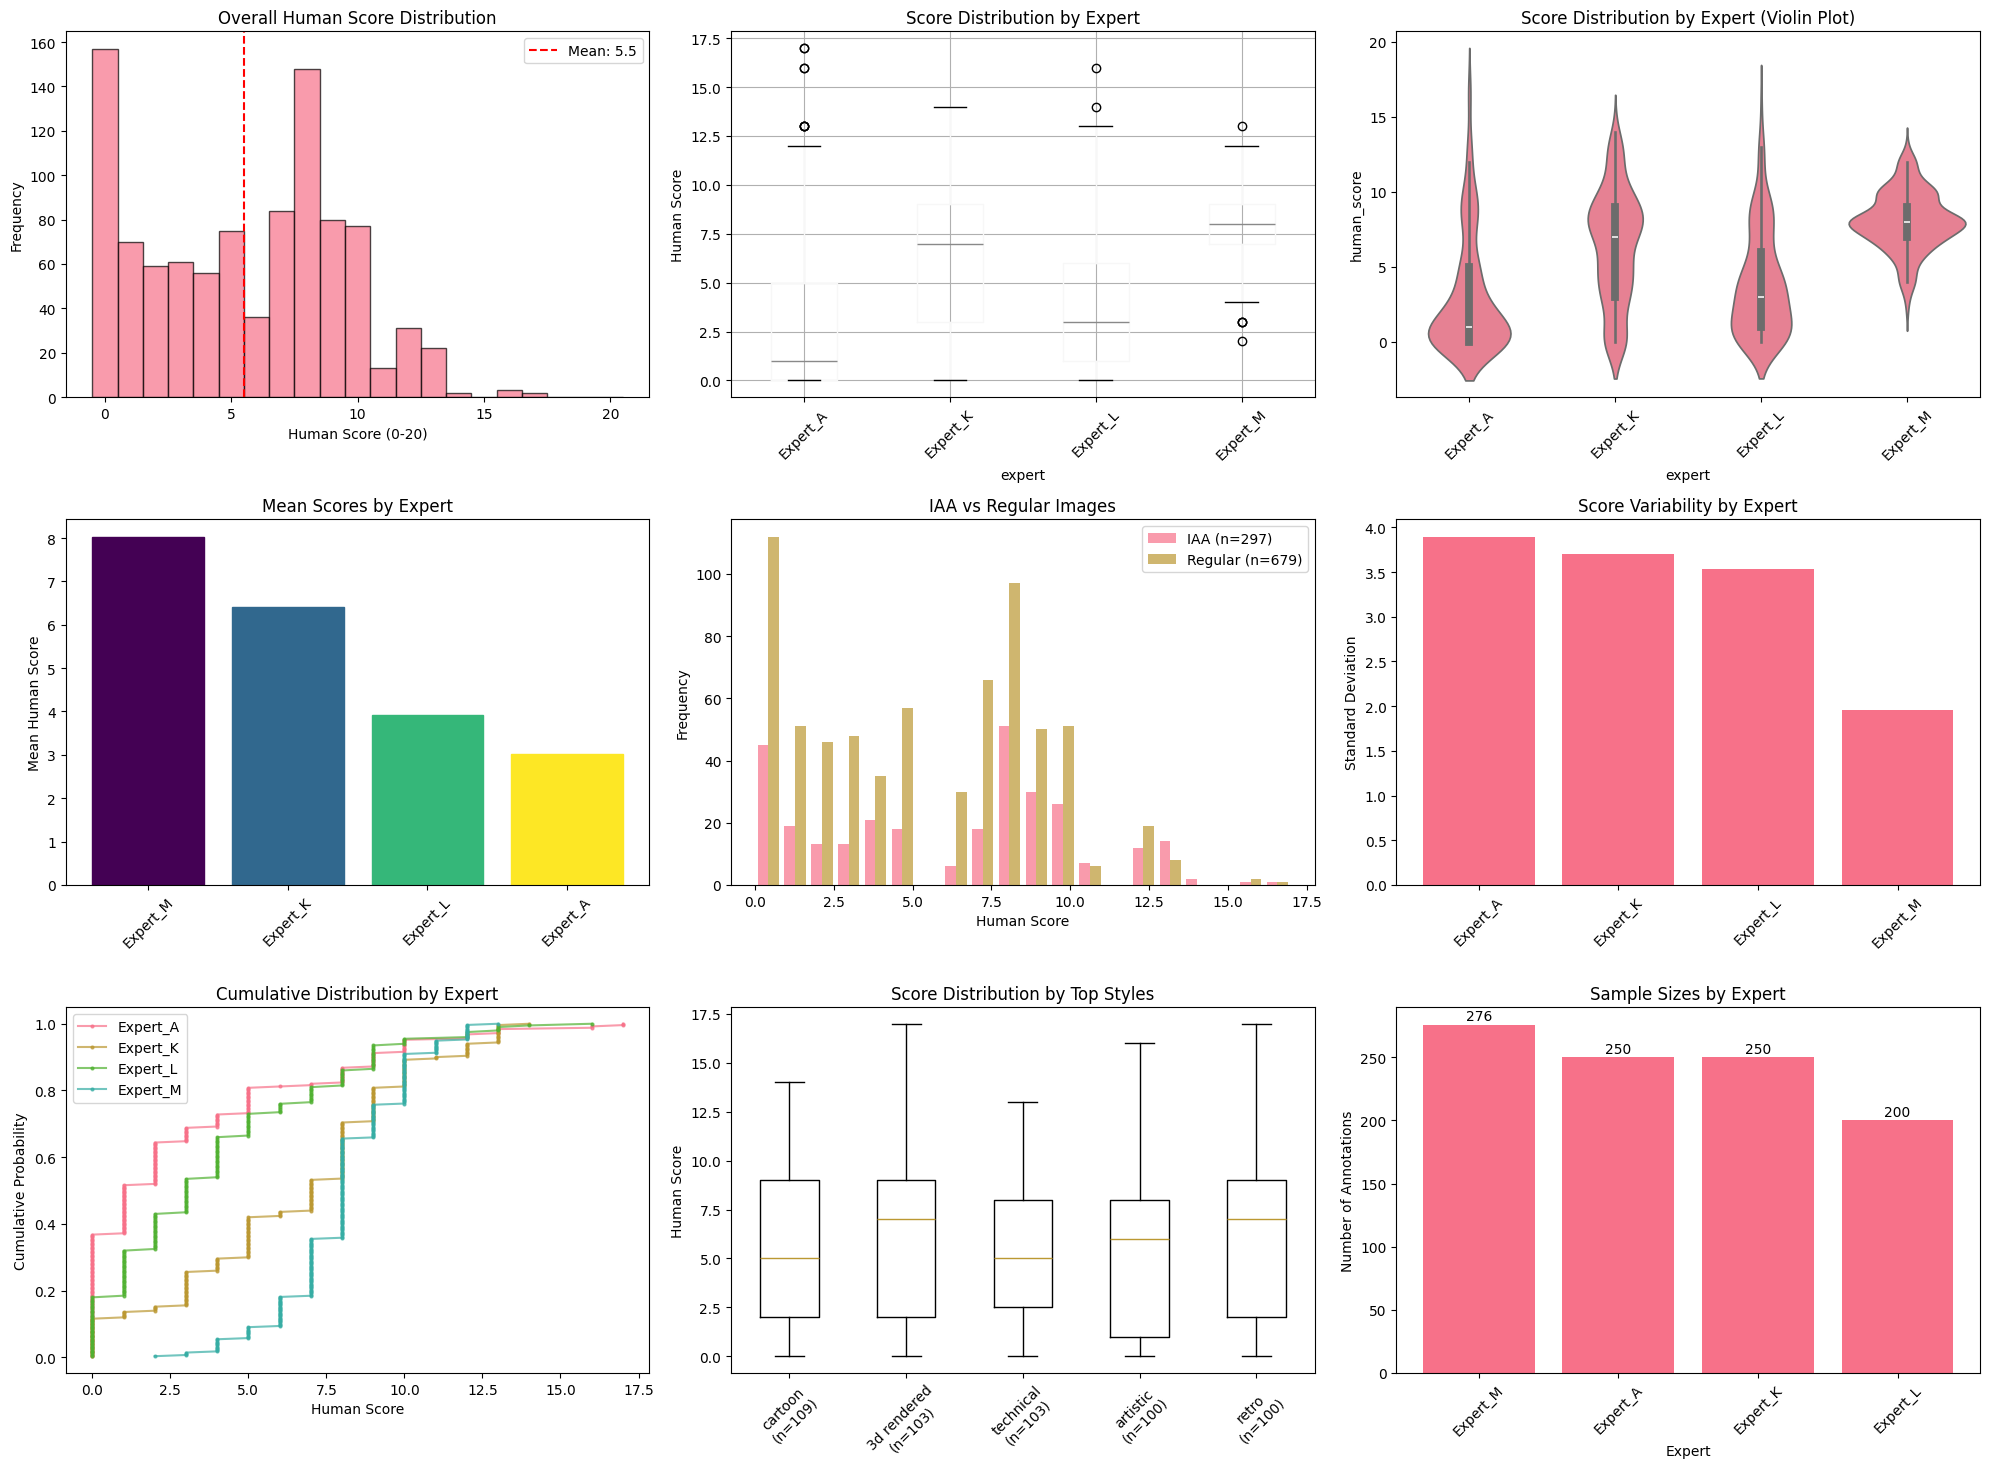

✓ Visualizations saved as 'step2_human_score_analysis.png'

SUMMARY REPORT
🔍 KEY FINDINGS:

1. EXPERT SCORING PATTERNS:
  🎯 Highest average scorer: Expert_M (8.03)
  🎯 Lowest average scorer: Expert_A (3.02)
  📊 Score range difference: 5.01 points

2. SCALE UTILIZATION:
  📏 Overall range used: 0 - 17 out of 20
  📈 Scale utilization: 85.0% of full scale

3. SCORING CONSISTENCY:
  🔄 Most variable: Expert_A (σ = 3.90)
  🎯 Most consistent: Expert_M (σ = 1.96)

4. IAA vs REGULAR IMAGES:
  🔍 IAA images mean score: 6.13
  📷 Regular images mean score: 5.21
  📊 Difference: 0.93 points

5. DATASET OVERVIEW:
  📊 Total annotations: 976
  🔍 IAA annotations: 297 (30.4%)
  📷 Regular annotations: 679 (69.6%)
  🎨 Unique styles: 10

💡 RECOMMENDATIONS FOR CLIP ANALYSIS:
  1. Expected expert differences in CLIP correlation due to scoring bias
  2. Z-score standardization crucial due to 5.0 point range
  3. Consider per-expert analysis given scoring pattern differences
  4. 976 annotations provide good stat

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def step2_load_mapped_data():
    """Load the mapped dataset from Step 1"""
    print("="*60)
    print("STEP 2: HUMAN SCORE DISTRIBUTION ANALYSIS")
    print("="*60)
    
    try:
        df = pd.read_csv('step1_mapped_annotations.csv')
        print(f"✓ Loaded mapped dataset: {len(df)} annotations")
        print(f"Experts: {df['expert'].unique()}")
        print(f"Score range: {df['human_score'].min()} - {df['human_score'].max()}")
        return df
    except FileNotFoundError:
        print("✗ Mapped dataset not found. Please run Step 1 first.")
        return None

def step2_overall_score_statistics(df):
    """Analyze overall human score statistics"""
    print(f"\n" + "="*50)
    print("OVERALL HUMAN SCORE STATISTICS")
    print("="*50)
    
    scores = df['human_score']
    
    print(f"Total annotations: {len(scores)}")
    print(f"Score range: {scores.min()} - {scores.max()} (out of 20)")
    print(f"Mean: {scores.mean():.2f}")
    print(f"Median: {scores.median():.2f}")
    print(f"Standard deviation: {scores.std():.2f}")
    print(f"Variance: {scores.var():.2f}")
    
    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"\nPercentiles:")
    for p in percentiles:
        value = np.percentile(scores, p)
        print(f"  {p}th percentile: {value:.1f}")
    
    # Distribution shape
    skewness = stats.skew(scores)
    kurtosis = stats.kurtosis(scores)
    print(f"\nDistribution shape:")
    print(f"  Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed' if skewness < 0 else 'symmetric'})")
    print(f"  Kurtosis: {kurtosis:.3f} ({'heavy-tailed' if kurtosis > 0 else 'light-tailed' if kurtosis < 0 else 'normal-tailed'})")

def step2_expert_comparison(df):
    """Compare scoring patterns across experts"""
    print(f"\n" + "="*50)
    print("EXPERT SCORING COMPARISON")
    print("="*50)
    
    expert_stats = df.groupby('expert')['human_score'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max', 'var'
    ]).round(2)
    
    print("Expert Statistics:")
    print(expert_stats.to_string())
    
    # Statistical tests between experts
    print(f"\n📊 EXPERT COMPARISON TESTS:")
    experts = df['expert'].unique()
    
    # ANOVA test
    expert_groups = [df[df['expert'] == expert]['human_score'] for expert in experts]
    f_stat, p_value = stats.f_oneway(*expert_groups)
    
    print(f"One-way ANOVA:")
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  p-value: {p_value:.6f}")
    if p_value < 0.001:
        print(f"  Result: Highly significant differences between experts (p < 0.001)")
    elif p_value < 0.01:
        print(f"  Result: Very significant differences between experts (p < 0.01)")
    elif p_value < 0.05:
        print(f"  Result: Significant differences between experts (p < 0.05)")
    else:
        print(f"  Result: No significant differences between experts (p ≥ 0.05)")
    
    # Pairwise comparisons
    print(f"\n🔍 PAIRWISE EXPERT COMPARISONS:")
    for i, expert1 in enumerate(experts):
        for expert2 in experts[i+1:]:
            scores1 = df[df['expert'] == expert1]['human_score']
            scores2 = df[df['expert'] == expert2]['human_score']
            
            # Mann-Whitney U test (non-parametric)
            statistic, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
            
            diff_means = scores1.mean() - scores2.mean()
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            print(f"  {expert1} vs {expert2}: Δμ = {diff_means:+.2f}, p = {p_val:.4f} {significance}")

def step2_score_distribution_analysis(df):
    """Analyze how experts use the 0-20 scale"""
    print(f"\n" + "="*50)
    print("SCORE DISTRIBUTION PATTERNS")
    print("="*50)
    
    for expert in df['expert'].unique():
        expert_scores = df[df['expert'] == expert]['human_score']
        
        print(f"\n--- {expert} ---")
        print(f"  Sample size: {len(expert_scores)}")
        print(f"  Range used: {expert_scores.min()} - {expert_scores.max()} (out of 20)")
        print(f"  Scale utilization: {(expert_scores.max() - expert_scores.min()) / 20 * 100:.1f}%")
        
        # Most common scores
        value_counts = expert_scores.value_counts().head(5)
        print(f"  Most frequent scores: {dict(value_counts)}")
        
        # Concentration around mean
        within_1_std = np.sum(np.abs(expert_scores - expert_scores.mean()) <= expert_scores.std()) / len(expert_scores) * 100
        print(f"  Scores within 1 std of mean: {within_1_std:.1f}%")

def step2_iaa_vs_regular_analysis(df):
    """Compare scoring patterns for IAA vs regular images"""
    print(f"\n" + "="*50)
    print("IAA vs REGULAR IMAGE SCORING")
    print("="*50)
    
    iaa_scores = df[df['is_iaa']]['human_score']
    regular_scores = df[~df['is_iaa']]['human_score']
    
    print(f"IAA images:")
    print(f"  Count: {len(iaa_scores)}")
    print(f"  Mean: {iaa_scores.mean():.2f}")
    print(f"  Std: {iaa_scores.std():.2f}")
    
    print(f"\nRegular images:")
    print(f"  Count: {len(regular_scores)}")
    print(f"  Mean: {regular_scores.mean():.2f}")
    print(f"  Std: {regular_scores.std():.2f}")
    
    # Statistical test
    statistic, p_value = stats.mannwhitneyu(iaa_scores, regular_scores, alternative='two-sided')
    print(f"\nMann-Whitney U test:")
    print(f"  Statistic: {statistic}")
    print(f"  p-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"  Result: Significant difference between IAA and regular image scores")
    else:
        print(f"  Result: No significant difference between IAA and regular image scores")

def step2_style_scoring_analysis(df):
    """Analyze scoring patterns by image style"""
    print(f"\n" + "="*50)
    print("SCORING PATTERNS BY IMAGE STYLE")
    print("="*50)
    
    # Get top styles by count
    top_styles = df['style'].value_counts().head(10)
    print(f"Top 10 styles by annotation count:")
    print(top_styles)
    
    # Statistical analysis by style
    print(f"\nStyle scoring statistics:")
    style_stats = df.groupby('style')['human_score'].agg([
        'count', 'mean', 'std'
    ]).round(2)
    
    # Filter styles with enough data
    style_stats_filtered = style_stats[style_stats['count'] >= 10].sort_values('mean', ascending=False)
    print(style_stats_filtered.head(10))
    
    # Test for differences between styles
    if len(style_stats_filtered) > 2:
        style_groups = []
        style_names = []
        for style in style_stats_filtered.index[:5]:  # Top 5 styles with most data
            scores = df[df['style'] == style]['human_score']
            if len(scores) >= 10:
                style_groups.append(scores)
                style_names.append(style)
        
        if len(style_groups) > 2:
            f_stat, p_value = stats.f_oneway(*style_groups)
            print(f"\nANOVA test across top styles:")
            print(f"  F-statistic: {f_stat:.3f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Styles tested: {style_names}")

def step2_create_visualizations(df):
    """Create comprehensive visualizations of human score distributions"""
    print(f"\n" + "="*50)
    print("CREATING VISUALIZATIONS")
    print("="*50)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Overall score distribution
    ax1 = plt.subplot(3, 3, 1)
    plt.hist(df['human_score'], bins=21, alpha=0.7, edgecolor='black', range=(-0.5, 20.5))
    plt.xlabel('Human Score (0-20)')
    plt.ylabel('Frequency')
    plt.title('Overall Human Score Distribution')
    plt.axvline(df['human_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["human_score"].mean():.1f}')
    plt.legend()
    
    # 2. Box plot by expert
    ax2 = plt.subplot(3, 3, 2)
    df.boxplot(column='human_score', by='expert', ax=ax2)
    plt.title('Score Distribution by Expert')
    plt.suptitle('')  # Remove automatic title
    plt.ylabel('Human Score')
    plt.xticks(rotation=45)
    
    # 3. Violin plot by expert
    ax3 = plt.subplot(3, 3, 3)
    sns.violinplot(data=df, x='expert', y='human_score', ax=ax3)
    plt.title('Score Distribution by Expert (Violin Plot)')
    plt.xticks(rotation=45)
    
    # 4. Mean scores by expert
    ax4 = plt.subplot(3, 3, 4)
    expert_means = df.groupby('expert')['human_score'].mean().sort_values(ascending=False)
    bars = plt.bar(range(len(expert_means)), expert_means.values)
    plt.xticks(range(len(expert_means)), expert_means.index, rotation=45)
    plt.ylabel('Mean Human Score')
    plt.title('Mean Scores by Expert')
    
    # Color bars from low to high
    colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # 5. IAA vs Regular comparison
    ax5 = plt.subplot(3, 3, 5)
    iaa_scores = df[df['is_iaa']]['human_score']
    regular_scores = df[~df['is_iaa']]['human_score']
    
    plt.hist([iaa_scores, regular_scores], bins=20, alpha=0.7, 
             label=[f'IAA (n={len(iaa_scores)})', f'Regular (n={len(regular_scores)})'])
    plt.xlabel('Human Score')
    plt.ylabel('Frequency')
    plt.title('IAA vs Regular Images')
    plt.legend()
    
    # 6. Score variance by expert
    ax6 = plt.subplot(3, 3, 6)
    expert_std = df.groupby('expert')['human_score'].std().sort_values(ascending=False)
    plt.bar(range(len(expert_std)), expert_std.values)
    plt.xticks(range(len(expert_std)), expert_std.index, rotation=45)
    plt.ylabel('Standard Deviation')
    plt.title('Score Variability by Expert')
    
    # 7. Cumulative distribution by expert
    ax7 = plt.subplot(3, 3, 7)
    for expert in df['expert'].unique():
        expert_scores = df[df['expert'] == expert]['human_score'].sort_values()
        y = np.arange(1, len(expert_scores) + 1) / len(expert_scores)
        plt.plot(expert_scores, y, label=expert, marker='o', markersize=2, alpha=0.7)
    
    plt.xlabel('Human Score')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution by Expert')
    plt.legend()
    
    # 8. Score distribution by top styles
    ax8 = plt.subplot(3, 3, 8)
    top_styles = df['style'].value_counts().head(5).index
    style_data = []
    style_labels = []
    
    for style in top_styles:
        style_scores = df[df['style'] == style]['human_score']
        if len(style_scores) > 5:
            style_data.append(style_scores)
            style_labels.append(f"{style}\n(n={len(style_scores)})")
    
    if style_data:
        plt.boxplot(style_data, labels=style_labels)
        plt.ylabel('Human Score')
        plt.title('Score Distribution by Top Styles')
        plt.xticks(rotation=45)
    
    # 9. Sample sizes
    ax9 = plt.subplot(3, 3, 9)
    sample_sizes = df['expert'].value_counts()
    plt.bar(sample_sizes.index, sample_sizes.values)
    plt.xlabel('Expert')
    plt.ylabel('Number of Annotations')
    plt.title('Sample Sizes by Expert')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(sample_sizes.values):
        plt.text(i, v + 1, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('step2_human_score_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualizations saved as 'step2_human_score_analysis.png'")

def step2_generate_summary_report(df):
    """Generate a summary report of findings"""
    print(f"\n" + "="*50)
    print("SUMMARY REPORT")
    print("="*50)
    
    print("🔍 KEY FINDINGS:")
    
    # Expert scoring patterns
    expert_means = df.groupby('expert')['human_score'].mean().sort_values(ascending=False)
    highest_scorer = expert_means.index[0]
    lowest_scorer = expert_means.index[-1]
    
    print(f"\n1. EXPERT SCORING PATTERNS:")
    print(f"  🎯 Highest average scorer: {highest_scorer} ({expert_means[highest_scorer]:.2f})")
    print(f"  🎯 Lowest average scorer: {lowest_scorer} ({expert_means[lowest_scorer]:.2f})")
    print(f"  📊 Score range difference: {expert_means[highest_scorer] - expert_means[lowest_scorer]:.2f} points")
    
    # Scale utilization
    overall_range = df['human_score'].max() - df['human_score'].min()
    scale_utilization = overall_range / 20 * 100
    print(f"\n2. SCALE UTILIZATION:")
    print(f"  📏 Overall range used: {df['human_score'].min()} - {df['human_score'].max()} out of 20")
    print(f"  📈 Scale utilization: {scale_utilization:.1f}% of full scale")
    
    # Most/least variable expert
    expert_std = df.groupby('expert')['human_score'].std()
    most_variable = expert_std.idxmax()
    least_variable = expert_std.idxmin()
    
    print(f"\n3. SCORING CONSISTENCY:")
    print(f"  🔄 Most variable: {most_variable} (σ = {expert_std[most_variable]:.2f})")
    print(f"  🎯 Most consistent: {least_variable} (σ = {expert_std[least_variable]:.2f})")
    
    # IAA vs Regular
    iaa_mean = df[df['is_iaa']]['human_score'].mean()
    regular_mean = df[~df['is_iaa']]['human_score'].mean()
    
    print(f"\n4. IAA vs REGULAR IMAGES:")
    print(f"  🔍 IAA images mean score: {iaa_mean:.2f}")
    print(f"  📷 Regular images mean score: {regular_mean:.2f}")
    print(f"  📊 Difference: {iaa_mean - regular_mean:.2f} points")
    
    # Sample sizes
    total_annotations = len(df)
    iaa_count = df['is_iaa'].sum()
    
    print(f"\n5. DATASET OVERVIEW:")
    print(f"  📊 Total annotations: {total_annotations}")
    print(f"  🔍 IAA annotations: {iaa_count} ({iaa_count/total_annotations*100:.1f}%)")
    print(f"  📷 Regular annotations: {total_annotations - iaa_count} ({(total_annotations-iaa_count)/total_annotations*100:.1f}%)")
    print(f"  🎨 Unique styles: {df['style'].nunique()}")
    
    print(f"\n💡 RECOMMENDATIONS FOR CLIP ANALYSIS:")
    print(f"  1. Expected expert differences in CLIP correlation due to scoring bias")
    print(f"  2. Z-score standardization crucial due to {expert_means.max() - expert_means.min():.1f} point range")
    print(f"  3. Consider per-expert analysis given scoring pattern differences")
    print(f"  4. {total_annotations} annotations provide good statistical power")

def run_step2():
    """Run complete Step 2: Human Score Distribution Analysis"""
    print("STEP 2: HUMAN SCORE DISTRIBUTION ANALYSIS")
    print("="*60)
    
    # Load mapped data from Step 1
    df = step2_load_mapped_data()
    if df is None:
        return None
    
    # Run all analyses
    step2_overall_score_statistics(df)
    step2_expert_comparison(df)
    step2_score_distribution_analysis(df)
    step2_iaa_vs_regular_analysis(df)
    step2_style_scoring_analysis(df)
    step2_create_visualizations(df)
    step2_generate_summary_report(df)
    
    # Save detailed results
    expert_summary = df.groupby('expert')['human_score'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(3)
    expert_summary.to_csv('step2_expert_scoring_summary.csv')
    
    style_summary = df.groupby('style')['human_score'].agg([
        'count', 'mean', 'std'
    ]).round(3)
    style_summary.to_csv('step2_style_scoring_summary.csv')
    
    print(f"\n✅ STEP 2 COMPLETE!")
    print(f"📊 Human score analysis complete for {len(df)} annotations")
    print(f"💾 Results saved to:")
    print(f"  - step2_human_score_analysis.png")
    print(f"  - step2_expert_scoring_summary.csv")
    print(f"  - step2_style_scoring_summary.csv")
    
    return df

if __name__ == "__main__":
    results = run_step2()

# Step 2: Human Score Distribution Analysis

STEP 2: EXPERT ANALYSIS PIPELINE
Creating Expert Summary Table...

Expert Summary Statistics:

          Sample Size  Mean  Median  Std Dev  Min  Max  Scale Usage (%)
Expert A          250  3.02     1.0     3.90    0   17             85.0
Expert K          250  6.42     7.0     3.71    0   14             70.0
Expert L          200  3.92     3.0     3.53    0   16             80.0
Expert M          276  8.03     8.0     1.96    2   13             55.0

✓ Summary table saved to: expert_summary_table.csv

Creating Expert Mean Scores Bar Chart...


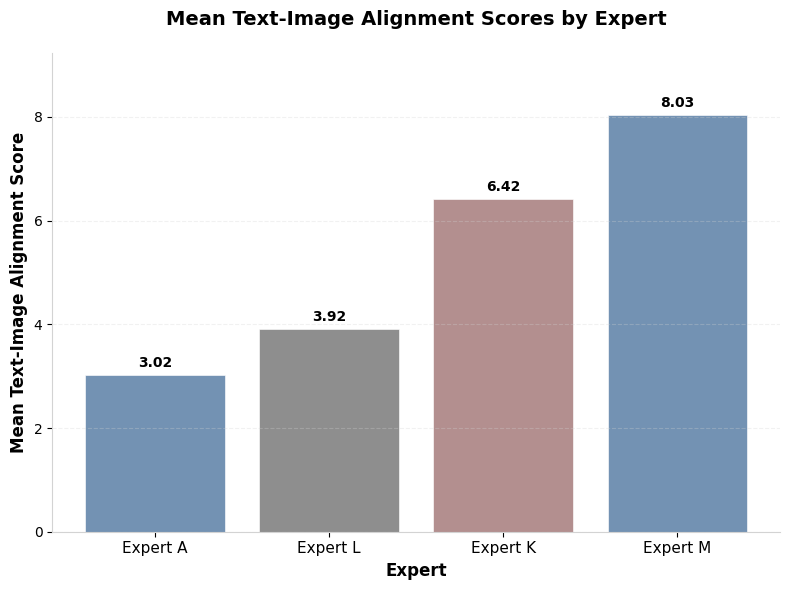

✓ Bar chart saved as: expert_mean_scores_chart.png and expert_mean_scores_chart.pdf

Overall Dataset Summary:
Total Annotations         976
Overall Mean Score        5.49
Overall Std Dev           3.89
Score Range               0 - 17 (out of 20)
Unique Styles             10

✅ STEP 2 COMPLETE!
Files created:
- expert_summary_table.csv
- expert_mean_scores_chart.png
- expert_mean_scores_chart.pdf

🔍 KEY INSIGHTS:
• Highest scoring expert: Expert M (8.03)
• Lowest scoring expert: Expert A (3.02)
• Score difference: 5.01 points
• This represents a 25.1% difference on the 20-point scale


In [21]:
# thesis_expert_analysis.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Unified Thesis Color Palette (exactly matching your IAA visualizations)
THESIS_COLORS = {
    'primary_blue': '#5B7FA6',
    'primary_red': '#A67C7C',
    'gray': '#7A7A7A',
    'white_edge': 'white',
    'light_blue': '#8FA8C7',
    'light_red': '#C4A5A5',
    'light_gray': '#E8E8E8',
    'dark_blue': '#4A6B8A',
    'dark_red': '#8B6B6B',
    'accent': '#6B8E6B',
    'neutral': '#9B9B9B'
}

# Load your annotated data
df = pd.read_csv('step1_mapped_annotations.csv')

# --------------------------------------------------------------------------
# Expert summary statistics table
# --------------------------------------------------------------------------

def create_expert_summary_table():
    print("Creating Expert Summary Table...")

    expert_stats = df.groupby('expert')['human_score'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)

    expert_stats.columns = ['Sample Size', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

    expert_labels = {
        'Expert_A': 'Expert A',
        'Expert_K': 'Expert K',
        'Expert_L': 'Expert L',
        'Expert_M': 'Expert M'
    }
    expert_stats.index = [expert_labels[idx] for idx in expert_stats.index]

    expert_stats['Scale Usage (%)'] = ((expert_stats['Max'] - expert_stats['Min']) / 20 * 100).round(1)

    print("\nExpert Summary Statistics:\n")
    print(expert_stats.to_string())

    expert_stats.to_csv('expert_summary_table.csv')
    print("\n✓ Summary table saved to: expert_summary_table.csv")

    return expert_stats

# --------------------------------------------------------------------------
# Expert mean score bar chart
# --------------------------------------------------------------------------

def create_expert_mean_scores_chart():
    print("\nCreating Expert Mean Scores Bar Chart...")

    expert_means = df.groupby('expert')['human_score'].mean().sort_values(ascending=True)

    expert_labels = {
        'Expert_A': 'Expert A',
        'Expert_K': 'Expert K',
        'Expert_L': 'Expert L',
        'Expert_M': 'Expert M'
    }
    expert_means.index = [expert_labels[idx] for idx in expert_means.index]

    # Robust color mapping (matching your thesis color identity)
    color_map = {
        'Expert A': THESIS_COLORS['primary_blue'],
        'Expert K': THESIS_COLORS['primary_red'],
        'Expert L': THESIS_COLORS['gray'],
        'Expert M': THESIS_COLORS['primary_blue']  # can adjust if you want a second tone
    }

    expert_colors = [color_map[expert] for expert in expert_means.index]

    # Plot
    plt.figure(figsize=(8, 6))

    bars = plt.bar(range(len(expert_means)), expert_means.values,
                   color=expert_colors, 
                   alpha=0.85,
                   edgecolor=THESIS_COLORS['white_edge'],
                   linewidth=0.5)

    plt.xlabel('Expert', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Text-Image Alignment Score', fontsize=12, fontweight='bold')
    plt.title('Mean Text-Image Alignment Scores by Expert', fontsize=14, fontweight='bold', pad=20)
    plt.xticks(range(len(expert_means)), expert_means.index, fontsize=11)

    for bar, value in zip(bars, expert_means.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{value:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.grid(axis='y', alpha=0.3, linestyle='--', color='lightgray')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('lightgray')
    plt.gca().spines['bottom'].set_color('lightgray')

    plt.ylim(0, max(expert_means.values) * 1.15)
    plt.tight_layout()

    plt.savefig('expert_mean_scores_chart.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig('expert_mean_scores_chart.pdf', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print("✓ Bar chart saved as: expert_mean_scores_chart.png and expert_mean_scores_chart.pdf")

    return expert_means

# --------------------------------------------------------------------------
# Global dataset summary
# --------------------------------------------------------------------------

def create_overall_summary():
    print("\nOverall Dataset Summary:")
    print("=" * 50)

    total_annotations = len(df)

    overall_stats = {
        'Total Annotations': total_annotations,
        'Overall Mean Score': f"{df['human_score'].mean():.2f}",
        'Overall Std Dev': f"{df['human_score'].std():.2f}",
        'Score Range': f"{df['human_score'].min()} - {df['human_score'].max()} (out of 20)",
        'Unique Styles': df['style'].nunique()
    }

    for key, value in overall_stats.items():
        print(f"{key:<25} {value}")

    return overall_stats

# --------------------------------------------------------------------------
# Full main pipeline
# --------------------------------------------------------------------------

def main():
    print("STEP 2: EXPERT ANALYSIS PIPELINE")
    print("=" * 60)

    expert_summary = create_expert_summary_table()
    expert_means = create_expert_mean_scores_chart()
    overall_summary = create_overall_summary()

    print(f"\n✅ STEP 2 COMPLETE!")
    print("Files created:")
    print("- expert_summary_table.csv")
    print("- expert_mean_scores_chart.png")
    print("- expert_mean_scores_chart.pdf")

    print(f"\n🔍 KEY INSIGHTS:")
    highest_scorer = expert_means.index[-1]
    lowest_scorer = expert_means.index[0]
    score_difference = expert_means.iloc[-1] - expert_means.iloc[0]

    print(f"• Highest scoring expert: {highest_scorer} ({expert_means.iloc[-1]:.2f})")
    print(f"• Lowest scoring expert: {lowest_scorer} ({expert_means.iloc[0]:.2f})")
    print(f"• Score difference: {score_difference:.2f} points")
    print(f"• This represents a {score_difference/20*100:.1f}% difference on the 20-point scale")

if __name__ == "__main__":
    main()


#  Step 3: CLIP Score Calculation. T

In [23]:
import json
import pandas as pd
import numpy as np
from PIL import Image
import torch
import clip
from pathlib import Path
import re
import os
from tqdm import tqdm

# File paths
REFINED_PROMPTS_FILE = r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files\refined_prompts.json'
IMAGE_DIR = r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\phase3_label_studio\2000_set_shuffled'
ANNOTATIONS_FILE = 'step1_mapped_annotations.csv'

def step3_load_refined_prompts():
    """Load the refined prompts JSON file"""
    print("="*60)
    print("STEP 3A: LOADING REFINED PROMPTS")
    print("="*60)
    
    try:
        with open(REFINED_PROMPTS_FILE, 'r', encoding='utf-8') as f:
            refined_prompts = json.load(f)
        
        print(f"✓ Refined prompts loaded successfully")
        print(f"📊 Total prompts: {len(refined_prompts)}")
        
        # Create lookup dictionary: id -> simplified_text
        prompts_dict = {}
        for item in refined_prompts:
            if 'id' in item and 'simplified_text' in item:
                prompts_dict[item['id']] = item['simplified_text']
        
        print(f"📋 Prompts dictionary created: {len(prompts_dict)} entries")
        
        # Show some examples
        print(f"\n📄 Example entries:")
        for i, (key, value) in enumerate(list(prompts_dict.items())[:3]):
            print(f"  {key}: {value[:100]}...")
        
        return prompts_dict
        
    except Exception as e:
        print(f"✗ Error loading refined prompts: {e}")
        return None

def step3_extract_dataset_info(actual_filename):
    """Extract dataset and dataset_id from actual image filename"""
    # Handle different filename patterns:
    # 0782_wikipedia_wikipedia_387_technical.png
    # 0801_onestopenglish_onestop_400_minimalistic.png
    
    # Special case for OneStopEnglish files
    if "onestopenglish_onestop" in actual_filename:
        pattern = r'(\d{4})_onestopenglish_onestop_(\d+)_(.+)\.png'
        match = re.match(pattern, actual_filename)
        
        if match:
            sequence_num = match.group(1)
            dataset_id = match.group(2)
            style = match.group(3)
            
            # For OneStopEnglish, use "onestop" as dataset name to match refined_prompts.json
            dataset = "onestop"
            lookup_key = f"onestop_{dataset_id}"
            
            return {
                'sequence_num': sequence_num,
                'dataset': dataset,
                'dataset_id': dataset_id,
                'style': style,
                'lookup_key': lookup_key
            }
    
    # General pattern for other datasets
    pattern = r'(\d{4})_([^_]+)_([^_]+)_(\d+)_(.+)\.png'
    match = re.match(pattern, actual_filename)
    
    if match:
        sequence_num = match.group(1)
        dataset1 = match.group(2)  # first dataset name
        dataset2 = match.group(3)  # second dataset name (should be same)
        dataset_id = match.group(4)
        style = match.group(5)
        
        # Use the first dataset name
        dataset = dataset1
        lookup_key = f"{dataset}_{dataset_id}"
        
        return {
            'sequence_num': sequence_num,
            'dataset': dataset,
            'dataset_id': dataset_id,
            'style': style,
            'lookup_key': lookup_key
        }
    else:
        return None

def step3_create_image_text_pairs(annotations_df, prompts_dict):
    """Create image-text pairs for CLIP calculation"""
    print("\n" + "="*60)
    print("STEP 3B: CREATING IMAGE-TEXT PAIRS")
    print("="*60)
    
    pairs = []
    successful_matches = 0
    failed_matches = []
    
    print(f"Processing {len(annotations_df)} annotations...")
    
    for idx, row in annotations_df.iterrows():
        actual_filename = row['actual_image_filename']
        
        # Extract dataset info from filename
        dataset_info = step3_extract_dataset_info(actual_filename)
        
        if dataset_info:
            lookup_key = dataset_info['lookup_key']
            
            # Find simplified text
            if lookup_key in prompts_dict:
                simplified_text = prompts_dict[lookup_key]
                
                pairs.append({
                    'annotation_id': idx,
                    'expert': row['expert'],
                    'label_studio_filename': row['label_studio_filename'],
                    'actual_image_filename': actual_filename,
                    'image_path': os.path.join(IMAGE_DIR, actual_filename),
                    'dataset': dataset_info['dataset'],
                    'dataset_id': dataset_info['dataset_id'],
                    'style': dataset_info['style'],
                    'lookup_key': lookup_key,
                    'simplified_text': simplified_text,
                    'human_score': row['human_score'],
                    'is_iaa': row['is_iaa']
                })
                successful_matches += 1
            else:
                failed_matches.append((actual_filename, lookup_key, "Text not found"))
        else:
            failed_matches.append((actual_filename, "N/A", "Filename pattern not matched"))
    
    print(f"✓ Successfully matched: {successful_matches}/{len(annotations_df)}")
    print(f"✗ Failed matches: {len(failed_matches)}")
    
    if len(failed_matches) > 0:
        print(f"\n⚠️ First 5 failed matches:")
        for i, (filename, lookup_key, reason) in enumerate(failed_matches[:5]):
            print(f"  {i+1}. {filename} → {lookup_key} → {reason}")
    
    if successful_matches > 0:
        print(f"\n✅ Example successful pairs:")
        for i in range(min(3, len(pairs))):
            pair = pairs[i]
            print(f"  {i+1}. {pair['actual_image_filename']}")
            print(f"     → {pair['lookup_key']}")
            print(f"     → {pair['simplified_text'][:80]}...")
            print(f"     → Human score: {pair['human_score']}")
    
    return pairs, failed_matches

def step3_calculate_clip_scores(pairs, batch_size=32):
    """Calculate CLIP scores for image-text pairs"""
    print("\n" + "="*60)
    print("STEP 3C: CALCULATING CLIP SCORES")
    print("="*60)
    
    # Load CLIP model
    print("Loading CLIP model (ViT-L/14@336px)...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14@336px", device=device)
    print(f"✓ CLIP ViT-L/14@336px model loaded on {device}")
    
    # Calculate scores in batches
    clip_scores = []
    successful_calculations = 0
    failed_calculations = []
    
    print(f"\nCalculating CLIP scores for {len(pairs)} pairs...")
    
    for i in tqdm(range(0, len(pairs), batch_size), desc="Processing batches"):
        batch_pairs = pairs[i:i+batch_size]
        batch_images = []
        batch_texts = []
        batch_indices = []
        
        # Prepare batch
        for j, pair in enumerate(batch_pairs):
            try:
                # Load and preprocess image
                image_path = pair['image_path']
                if os.path.exists(image_path):
                    image = Image.open(image_path).convert('RGB')
                    batch_images.append(preprocess(image))
                    batch_texts.append(pair['simplified_text'])
                    batch_indices.append(i + j)
                else:
                    failed_calculations.append((pair['actual_image_filename'], "Image file not found"))
            except Exception as e:
                failed_calculations.append((pair['actual_image_filename'], f"Image loading error: {e}"))
        
        if len(batch_images) > 0:
            try:
                # Convert to tensors
                batch_images = torch.stack(batch_images).to(device)
                batch_texts = clip.tokenize(batch_texts, truncate=True).to(device)
                
                # Calculate features
                with torch.no_grad():
                    image_features = model.encode_image(batch_images)
                    text_features = model.encode_text(batch_texts)
                    
                    # Normalize features
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                    
                    # Calculate cosine similarity (CLIP score)
                    similarities = (image_features * text_features).sum(dim=-1)
                    similarities = similarities.cpu().numpy()
                
                # Store results
                for idx, similarity in zip(batch_indices, similarities):
                    clip_scores.append({
                        'pair_index': idx,
                        'clip_score': float(similarity)
                    })
                    successful_calculations += 1
                    
            except Exception as e:
                for idx in batch_indices:
                    failed_calculations.append((pairs[idx]['actual_image_filename'], f"CLIP calculation error: {e}"))
    
    print(f"\n✓ Successfully calculated: {successful_calculations}/{len(pairs)}")
    print(f"✗ Failed calculations: {len(failed_calculations)}")
    
    if len(failed_calculations) > 0:
        print(f"\n⚠️ First 5 failed calculations:")
        for i, (filename, reason) in enumerate(failed_calculations[:5]):
            print(f"  {i+1}. {filename} → {reason}")
    
    return clip_scores, failed_calculations

def step3_combine_results(pairs, clip_scores):
    """Combine pairs with CLIP scores"""
    print("\n" + "="*60)
    print("STEP 3D: COMBINING RESULTS")
    print("="*60)
    
    # Create CLIP scores lookup
    clip_dict = {score['pair_index']: score['clip_score'] for score in clip_scores}
    
    # Add CLIP scores to pairs
    final_results = []
    for i, pair in enumerate(pairs):
        if i in clip_dict:
            pair['clip_score'] = clip_dict[i]
            final_results.append(pair)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(final_results)
    
    print(f"✓ Final dataset: {len(results_df)} complete pairs")
    
    # Show summary statistics
    print(f"\n📊 CLIP SCORE STATISTICS:")
    print(f"Mean CLIP score: {results_df['clip_score'].mean():.4f}")
    print(f"Std CLIP score: {results_df['clip_score'].std():.4f}")
    print(f"Min CLIP score: {results_df['clip_score'].min():.4f}")
    print(f"Max CLIP score: {results_df['clip_score'].max():.4f}")
    
    print(f"\n📊 HUMAN SCORE STATISTICS:")
    print(f"Mean human score: {results_df['human_score'].mean():.4f}")
    print(f"Std human score: {results_df['human_score'].std():.4f}")
    print(f"Min human score: {results_df['human_score'].min():.4f}")
    print(f"Max human score: {results_df['human_score'].max():.4f}")
    
    # Save results
    results_df.to_csv('step3_clip_human_scores.csv', index=False)
    print(f"\n💾 Results saved to: step3_clip_human_scores.csv")
    
    return results_df

def run_step3():
    """Run complete Step 3: CLIP Score Calculation"""
    print("STEP 3: CLIP SCORE CALCULATION")
    print("="*60)
    
    # Load previous results
    try:
        annotations_df = pd.read_csv(ANNOTATIONS_FILE)
        print(f"✓ Loaded annotations: {len(annotations_df)} entries")
    except Exception as e:
        print(f"✗ Error loading annotations: {e}")
        return None
    
    # Step 3A: Load refined prompts
    prompts_dict = step3_load_refined_prompts()
    if prompts_dict is None:
        return None
    
    # Step 3B: Create image-text pairs
    pairs, failed_matches = step3_create_image_text_pairs(annotations_df, prompts_dict)
    if len(pairs) == 0:
        print("✗ No valid pairs created")
        return None
    
    # Step 3C: Calculate CLIP scores
    clip_scores, failed_calculations = step3_calculate_clip_scores(pairs)
    if len(clip_scores) == 0:
        print("✗ No CLIP scores calculated")
        return None
    
    # Step 3D: Combine results
    final_results = step3_combine_results(pairs, clip_scores)
    
    print(f"\n✅ STEP 3 COMPLETE!")
    print(f"Final dataset: {len(final_results)} complete image-text pairs with both human and CLIP scores")
    
    return final_results

if __name__ == "__main__":
    results = run_step3()

STEP 3: CLIP SCORE CALCULATION
✓ Loaded annotations: 976 entries
STEP 3A: LOADING REFINED PROMPTS
✓ Refined prompts loaded successfully
📊 Total prompts: 400
📋 Prompts dictionary created: 400 entries

📄 Example entries:
  wikipedia_387: Originally, a pie made with any kind of meat and mashed potato was called a cottage pie ''....
  simpa_419: Cemeteries usually have 2 sections: a consecrated section (for Anglican burials) and an unconsecrate...
  asset_307: Prime lenses usually have a larger maximum aperture than zoom lenses....

STEP 3B: CREATING IMAGE-TEXT PAIRS
Processing 976 annotations...
✓ Successfully matched: 976/976
✗ Failed matches: 0

✅ Example successful pairs:
  1. 0005_asset_asset_137_realistic.png
     → asset_137
     → In 1810, the County Seat was later moved to the City of Daphne in 1868....
     → Human score: 2
  2. 0008_onestopenglish_onestop_092_storybook.png
     → onestop_092
     → One of the boyfriends wrote to me and said, Listen, shes not mad but Cynthia fou.

Processing batches: 100%|██████████| 31/31 [38:48<00:00, 75.10s/it]


✓ Successfully calculated: 976/976
✗ Failed calculations: 0

STEP 3D: COMBINING RESULTS
✓ Final dataset: 976 complete pairs

📊 CLIP SCORE STATISTICS:
Mean CLIP score: 0.2136
Std CLIP score: 0.0428
Min CLIP score: 0.0905
Max CLIP score: 0.3456

📊 HUMAN SCORE STATISTICS:
Mean human score: 5.4908
Std human score: 3.8905
Min human score: 0.0000
Max human score: 17.0000

💾 Results saved to: step3_clip_human_scores.csv

✅ STEP 3 COMPLETE!
Final dataset: 976 complete image-text pairs with both human and CLIP scores


#  Step 4 correlation analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# File paths
CLIP_HUMAN_SCORES_FILE = 'step3_clip_human_scores.csv'

def step4_load_data():
    """Step 4A: Load the combined CLIP and human scores"""
    print("="*60)
    print("STEP 4A: LOADING COMBINED SCORES")
    print("="*60)
    
    try:
        df = pd.read_csv(CLIP_HUMAN_SCORES_FILE)
        print(f"✓ Data loaded successfully")
        print(f"📊 Total records: {len(df)}")
        print(f"📋 Columns: {list(df.columns)}")
        
        # Basic data info
        print(f"\n📄 Dataset overview:")
        print(f"Experts: {sorted(df['expert'].unique())}")
        print(f"Styles: {sorted(df['style'].unique())}")
        print(f"Datasets: {sorted(df['dataset'].unique())}")
        
        # Check for missing values
        missing = df[['human_score', 'clip_score']].isnull().sum()
        print(f"\n🔍 Missing values:")
        print(f"Human scores: {missing['human_score']}")
        print(f"CLIP scores: {missing['clip_score']}")
        
        return df
        
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None

def step4_standardize_scores(df):
    """Step 4B: Apply different standardization methods"""
    print("\n" + "="*60)
    print("STEP 4B: STANDARDIZING SCORES")
    print("="*60)
    
    df = df.copy()
    
    # Method 1: Overall Z-score standardization
    print("Applying overall Z-score standardization...")
    df['human_z'] = (df['human_score'] - df['human_score'].mean()) / df['human_score'].std()
    df['clip_z'] = (df['clip_score'] - df['clip_score'].mean()) / df['clip_score'].std()
    
    # Method 2: Per-expert Z-score standardization
    print("Applying per-expert Z-score standardization...")
    df['human_expert_z'] = np.nan
    
    for expert in df['expert'].unique():
        mask = df['expert'] == expert
        expert_data = df[mask]
        
        if len(expert_data) > 1 and expert_data['human_score'].std() > 0:
            df.loc[mask, 'human_expert_z'] = (
                expert_data['human_score'] - expert_data['human_score'].mean()
            ) / expert_data['human_score'].std()
        
        print(f"  {expert}: {mask.sum()} scores standardized")
    
    # Method 3: Min-Max normalization (0-1 scale)
    print("Applying Min-Max normalization...")
    df['human_minmax'] = (df['human_score'] - df['human_score'].min()) / (df['human_score'].max() - df['human_score'].min())
    df['clip_minmax'] = (df['clip_score'] - df['clip_score'].min()) / (df['clip_score'].max() - df['clip_score'].min())
    
    print(f"\n✓ Standardization complete")
    print(f"📊 New columns added: human_z, clip_z, human_expert_z, human_minmax, clip_minmax")
    
    return df

def step4_overall_correlation(df):
    """Step 4C: Calculate overall correlations"""
    print("\n" + "="*60)
    print("STEP 4C: OVERALL CORRELATION ANALYSIS")
    print("="*60)
    
    correlations = {}
    
    # Raw scores correlation
    r_raw, p_raw = pearsonr(df['human_score'], df['clip_score'])
    correlations['raw_pearson'] = {'r': r_raw, 'p': p_raw}
    
    # Spearman correlation (rank-based)
    rho_raw, p_rho = spearmanr(df['human_score'], df['clip_score'])
    correlations['raw_spearman'] = {'r': rho_raw, 'p': p_rho}
    
    # Z-score standardized correlation
    r_z, p_z = pearsonr(df['human_z'], df['clip_z'])
    correlations['z_pearson'] = {'r': r_z, 'p': p_z}
    
    # Per-expert standardized correlation
    valid_expert_z = df.dropna(subset=['human_expert_z'])
    if len(valid_expert_z) > 0:
        r_expert_z, p_expert_z = pearsonr(valid_expert_z['human_expert_z'], valid_expert_z['clip_z'])
        correlations['expert_z_pearson'] = {'r': r_expert_z, 'p': p_expert_z}
    
    # Min-max normalized correlation
    r_minmax, p_minmax = pearsonr(df['human_minmax'], df['clip_minmax'])
    correlations['minmax_pearson'] = {'r': r_minmax, 'p': p_minmax}
    
    # Display results
    print("📊 OVERALL CORRELATION RESULTS:")
    print("="*50)
    
    for method, result in correlations.items():
        significance = "***" if result['p'] < 0.001 else "**" if result['p'] < 0.01 else "*" if result['p'] < 0.05 else ""
        print(f"{method:20s}: r = {result['r']:6.4f}, p = {result['p']:8.6f} {significance}")
    
    # Interpretation
    best_r = max(correlations.values(), key=lambda x: abs(x['r']))['r']
    print(f"\n🎯 INTERPRETATION:")
    
    if abs(best_r) >= 0.7:
        strength = "STRONG"
    elif abs(best_r) >= 0.5:
        strength = "MODERATE"
    elif abs(best_r) >= 0.3:
        strength = "WEAK"
    else:
        strength = "VERY WEAK"
    
    print(f"Best correlation: r = {best_r:.4f} ({strength} correlation)")
    print(f"Direction: {'Positive' if best_r > 0 else 'Negative'} correlation")
    
    return correlations

def step4_per_expert_analysis(df):
    """Step 4D: Per-expert correlation analysis"""
    print("\n" + "="*60)
    print("STEP 4D: PER-EXPERT CORRELATION ANALYSIS")
    print("="*60)
    
    expert_results = {}
    
    print("📊 EXPERT-WISE CORRELATIONS:")
    print("="*50)
    print(f"{'Expert':<10} {'Count':<6} {'Raw r':<8} {'Z-score r':<10} {'p-value':<10} {'Sig':<4}")
    print("-" * 50)
    
    for expert in sorted(df['expert'].unique()):
        expert_data = df[df['expert'] == expert].copy()
        
        if len(expert_data) > 2:  # Need at least 3 points for correlation
            # Raw correlation
            r_raw, p_raw = pearsonr(expert_data['human_score'], expert_data['clip_score'])
            
            # Z-score correlation (using overall standardization)
            r_z, p_z = pearsonr(expert_data['human_z'], expert_data['clip_z'])
            
            # Significance markers
            sig = "***" if p_raw < 0.001 else "**" if p_raw < 0.01 else "*" if p_raw < 0.05 else ""
            
            expert_results[expert] = {
                'count': len(expert_data),
                'raw_r': r_raw,
                'z_r': r_z,
                'p_value': p_raw,
                'human_mean': expert_data['human_score'].mean(),
                'human_std': expert_data['human_score'].std(),
                'clip_mean': expert_data['clip_score'].mean(),
                'clip_std': expert_data['clip_score'].std()
            }
            
            print(f"{expert:<10} {len(expert_data):<6} {r_raw:<8.4f} {r_z:<10.4f} {p_raw:<10.6f} {sig:<4}")
    
    # Rank experts by correlation strength
    print(f"\n🏆 EXPERT RANKING (by raw correlation):")
    ranked_experts = sorted(expert_results.items(), key=lambda x: abs(x[1]['raw_r']), reverse=True)
    
    for i, (expert, results) in enumerate(ranked_experts, 1):
        print(f"{i}. {expert}: r = {results['raw_r']:.4f} (n = {results['count']})")
    
    # Expert scoring patterns
    print(f"\n📈 EXPERT SCORING PATTERNS:")
    print(f"{'Expert':<10} {'Human Mean':<12} {'Human Std':<11} {'CLIP Mean':<11} {'CLIP Std':<10}")
    print("-" * 55)
    
    for expert, results in expert_results.items():
        print(f"{expert:<10} {results['human_mean']:<12.2f} {results['human_std']:<11.2f} "
              f"{results['clip_mean']:<11.4f} {results['clip_std']:<10.4f}")
    
    return expert_results

def step4_per_style_analysis(df):
    """Step 4E: Per-style correlation analysis"""
    print("\n" + "="*60)
    print("STEP 4E: PER-STYLE CORRELATION ANALYSIS")
    print("="*60)
    
    style_results = {}
    
    print("📊 STYLE-WISE CORRELATIONS:")
    print("="*50)
    print(f"{'Style':<15} {'Count':<6} {'Raw r':<8} {'Z-score r':<10} {'p-value':<10} {'Sig':<4}")
    print("-" * 55)
    
    for style in sorted(df['style'].unique()):
        style_data = df[df['style'] == style].copy()
        
        if len(style_data) > 2:  # Need at least 3 points for correlation
            # Raw correlation
            r_raw, p_raw = pearsonr(style_data['human_score'], style_data['clip_score'])
            
            # Z-score correlation
            r_z, p_z = pearsonr(style_data['human_z'], style_data['clip_z'])
            
            # Significance markers
            sig = "***" if p_raw < 0.001 else "**" if p_raw < 0.01 else "*" if p_raw < 0.05 else ""
            
            style_results[style] = {
                'count': len(style_data),
                'raw_r': r_raw,
                'z_r': r_z,
                'p_value': p_raw,
                'human_mean': style_data['human_score'].mean(),
                'human_std': style_data['human_score'].std(),
                'clip_mean': style_data['clip_score'].mean(),
                'clip_std': style_data['clip_score'].std()
            }
            
            print(f"{style:<15} {len(style_data):<6} {r_raw:<8.4f} {r_z:<10.4f} {p_raw:<10.6f} {sig:<4}")
    
    # Rank styles by correlation strength
    print(f"\n🎨 STYLE RANKING (by raw correlation):")
    ranked_styles = sorted(style_results.items(), key=lambda x: abs(x[1]['raw_r']), reverse=True)
    
    for i, (style, results) in enumerate(ranked_styles, 1):
        print(f"{i:2d}. {style:<15}: r = {results['raw_r']:6.4f} (n = {results['count']})")
    
    # Best and worst performing styles
    if ranked_styles:
        best_style, best_results = ranked_styles[0]
        worst_style, worst_results = ranked_styles[-1]
        
        print(f"\n🏆 BEST STYLE: {best_style} (r = {best_results['raw_r']:.4f})")
        print(f"🔻 WORST STYLE: {worst_style} (r = {worst_results['raw_r']:.4f})")
    
    return style_results

def step4_dataset_analysis(df):
    """Step 4F: Per-dataset correlation analysis"""
    print("\n" + "="*60)
    print("STEP 4F: PER-DATASET CORRELATION ANALYSIS")
    print("="*60)
    
    dataset_results = {}
    
    print("📊 DATASET-WISE CORRELATIONS:")
    print("="*50)
    print(f"{'Dataset':<15} {'Count':<6} {'Raw r':<8} {'Z-score r':<10} {'p-value':<10} {'Sig':<4}")
    print("-" * 55)
    
    for dataset in sorted(df['dataset'].unique()):
        dataset_data = df[df['dataset'] == dataset].copy()
        
        if len(dataset_data) > 2:
            r_raw, p_raw = pearsonr(dataset_data['human_score'], dataset_data['clip_score'])
            r_z, p_z = pearsonr(dataset_data['human_z'], dataset_data['clip_z'])
            
            sig = "***" if p_raw < 0.001 else "**" if p_raw < 0.01 else "*" if p_raw < 0.05 else ""
            
            dataset_results[dataset] = {
                'count': len(dataset_data),
                'raw_r': r_raw,
                'z_r': r_z,
                'p_value': p_raw
            }
            
            print(f"{dataset:<15} {len(dataset_data):<6} {r_raw:<8.4f} {r_z:<10.4f} {p_raw:<10.6f} {sig:<4}")
    
    return dataset_results

def step4_save_results(df, correlations, expert_results, style_results, dataset_results):
    """Step 4G: Save all results"""
    print("\n" + "="*60)
    print("STEP 4G: SAVING RESULTS")
    print("="*60)
    
    # Save the standardized dataset
    df.to_csv('step4_standardized_scores.csv', index=False)
    print("✓ Standardized scores saved to: step4_standardized_scores.csv")
    
    # Save summary statistics
    summary_stats = {
        'overall_correlations': correlations,
        'expert_correlations': expert_results,
        'style_correlations': style_results,
        'dataset_correlations': dataset_results
    }
    
    # Convert to DataFrame for easy saving
    results_summary = []
    
    # Overall results
    for method, result in correlations.items():
        results_summary.append({
            'analysis_type': 'overall',
            'category': method,
            'correlation': result['r'],
            'p_value': result['p'],
            'count': len(df)
        })
    
    # Expert results
    for expert, result in expert_results.items():
        results_summary.append({
            'analysis_type': 'expert',
            'category': expert,
            'correlation': result['raw_r'],
            'p_value': result['p_value'],
            'count': result['count']
        })
    
    # Style results
    for style, result in style_results.items():
        results_summary.append({
            'analysis_type': 'style',
            'category': style,
            'correlation': result['raw_r'],
            'p_value': result['p_value'],
            'count': result['count']
        })
    
    # Dataset results
    for dataset, result in dataset_results.items():
        results_summary.append({
            'analysis_type': 'dataset',
            'category': dataset,
            'correlation': result['raw_r'],
            'p_value': result['p_value'],
            'count': result['count']
        })
    
    summary_df = pd.DataFrame(results_summary)
    summary_df.to_csv('step4_correlation_summary.csv', index=False)
    print("✓ Correlation summary saved to: step4_correlation_summary.csv")
    
    return summary_df

def run_step4():
    """Run complete Step 4: Correlation Analysis"""
    print("STEP 4: CORRELATION ANALYSIS")
    print("="*60)
    
    # Step 4A: Load data
    df = step4_load_data()
    if df is None:
        return None
    
    # Step 4B: Standardize scores
    df = step4_standardize_scores(df)
    
    # Step 4C: Overall correlation
    correlations = step4_overall_correlation(df)
    
    # Step 4D: Per-expert analysis
    expert_results = step4_per_expert_analysis(df)
    
    # Step 4E: Per-style analysis
    style_results = step4_per_style_analysis(df)
    
    # Step 4F: Per-dataset analysis
    dataset_results = step4_dataset_analysis(df)
    
    # Step 4G: Save results
    summary_df = step4_save_results(df, correlations, expert_results, style_results, dataset_results)
    
    print(f"\n✅ STEP 4 COMPLETE!")
    print(f"Analysis complete with comprehensive correlation results")
    print(f"Files generated:")
    print(f"  - step4_standardized_scores.csv (full dataset with standardized scores)")
    print(f"  - step4_correlation_summary.csv (summary of all correlations)")
    
    return df, summary_df

if __name__ == "__main__":
    # Execute the analysis
    results = run_step4()
    
    if results is not None:
        df, summary_df = results
        print(f"\n🎉 SUCCESS! Analysis complete with:")
        print(f"   - {len(df)} total pairs analyzed")
        print(f"   - {len(summary_df)} correlation results calculated")
        print(f"   - Multiple standardization methods applied")
        print(f"   - Results saved to CSV files")
    else:
        print("❌ Analysis failed - check error messages above")

STEP 4: CORRELATION ANALYSIS
STEP 4A: LOADING COMBINED SCORES
✓ Data loaded successfully
📊 Total records: 976
📋 Columns: ['annotation_id', 'expert', 'label_studio_filename', 'actual_image_filename', 'image_path', 'dataset', 'dataset_id', 'style', 'lookup_key', 'simplified_text', 'human_score', 'is_iaa', 'clip_score']

📄 Dataset overview:
Experts: ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
Styles: ['3d rendered', 'artistic', 'cartoon', 'digital art', 'geometric', 'minimalistic', 'realistic', 'retro', 'storybook', 'technical']
Datasets: ['asset', 'onestop', 'simpa', 'wikipedia']

🔍 Missing values:
Human scores: 0
CLIP scores: 0

STEP 4B: STANDARDIZING SCORES
Applying overall Z-score standardization...
Applying per-expert Z-score standardization...
  Expert_A: 250 scores standardized
  Expert_K: 250 scores standardized
  Expert_L: 200 scores standardized
  Expert_M: 276 scores standardized
Applying Min-Max normalization...

✓ Standardization complete
📊 New columns added: human_z, cl

# Step 5: CLIP-Human Correlation Visualizations & Summary


STEP 5: CLIP-HUMAN CORRELATION VISUALIZATIONS & SUMMARY
STEP 5: CLIP-HUMAN CORRELATION VISUALIZATIONS
✓ Data loaded: 976 pairs, 23 correlation results

📊 Creating overall scatter plot...


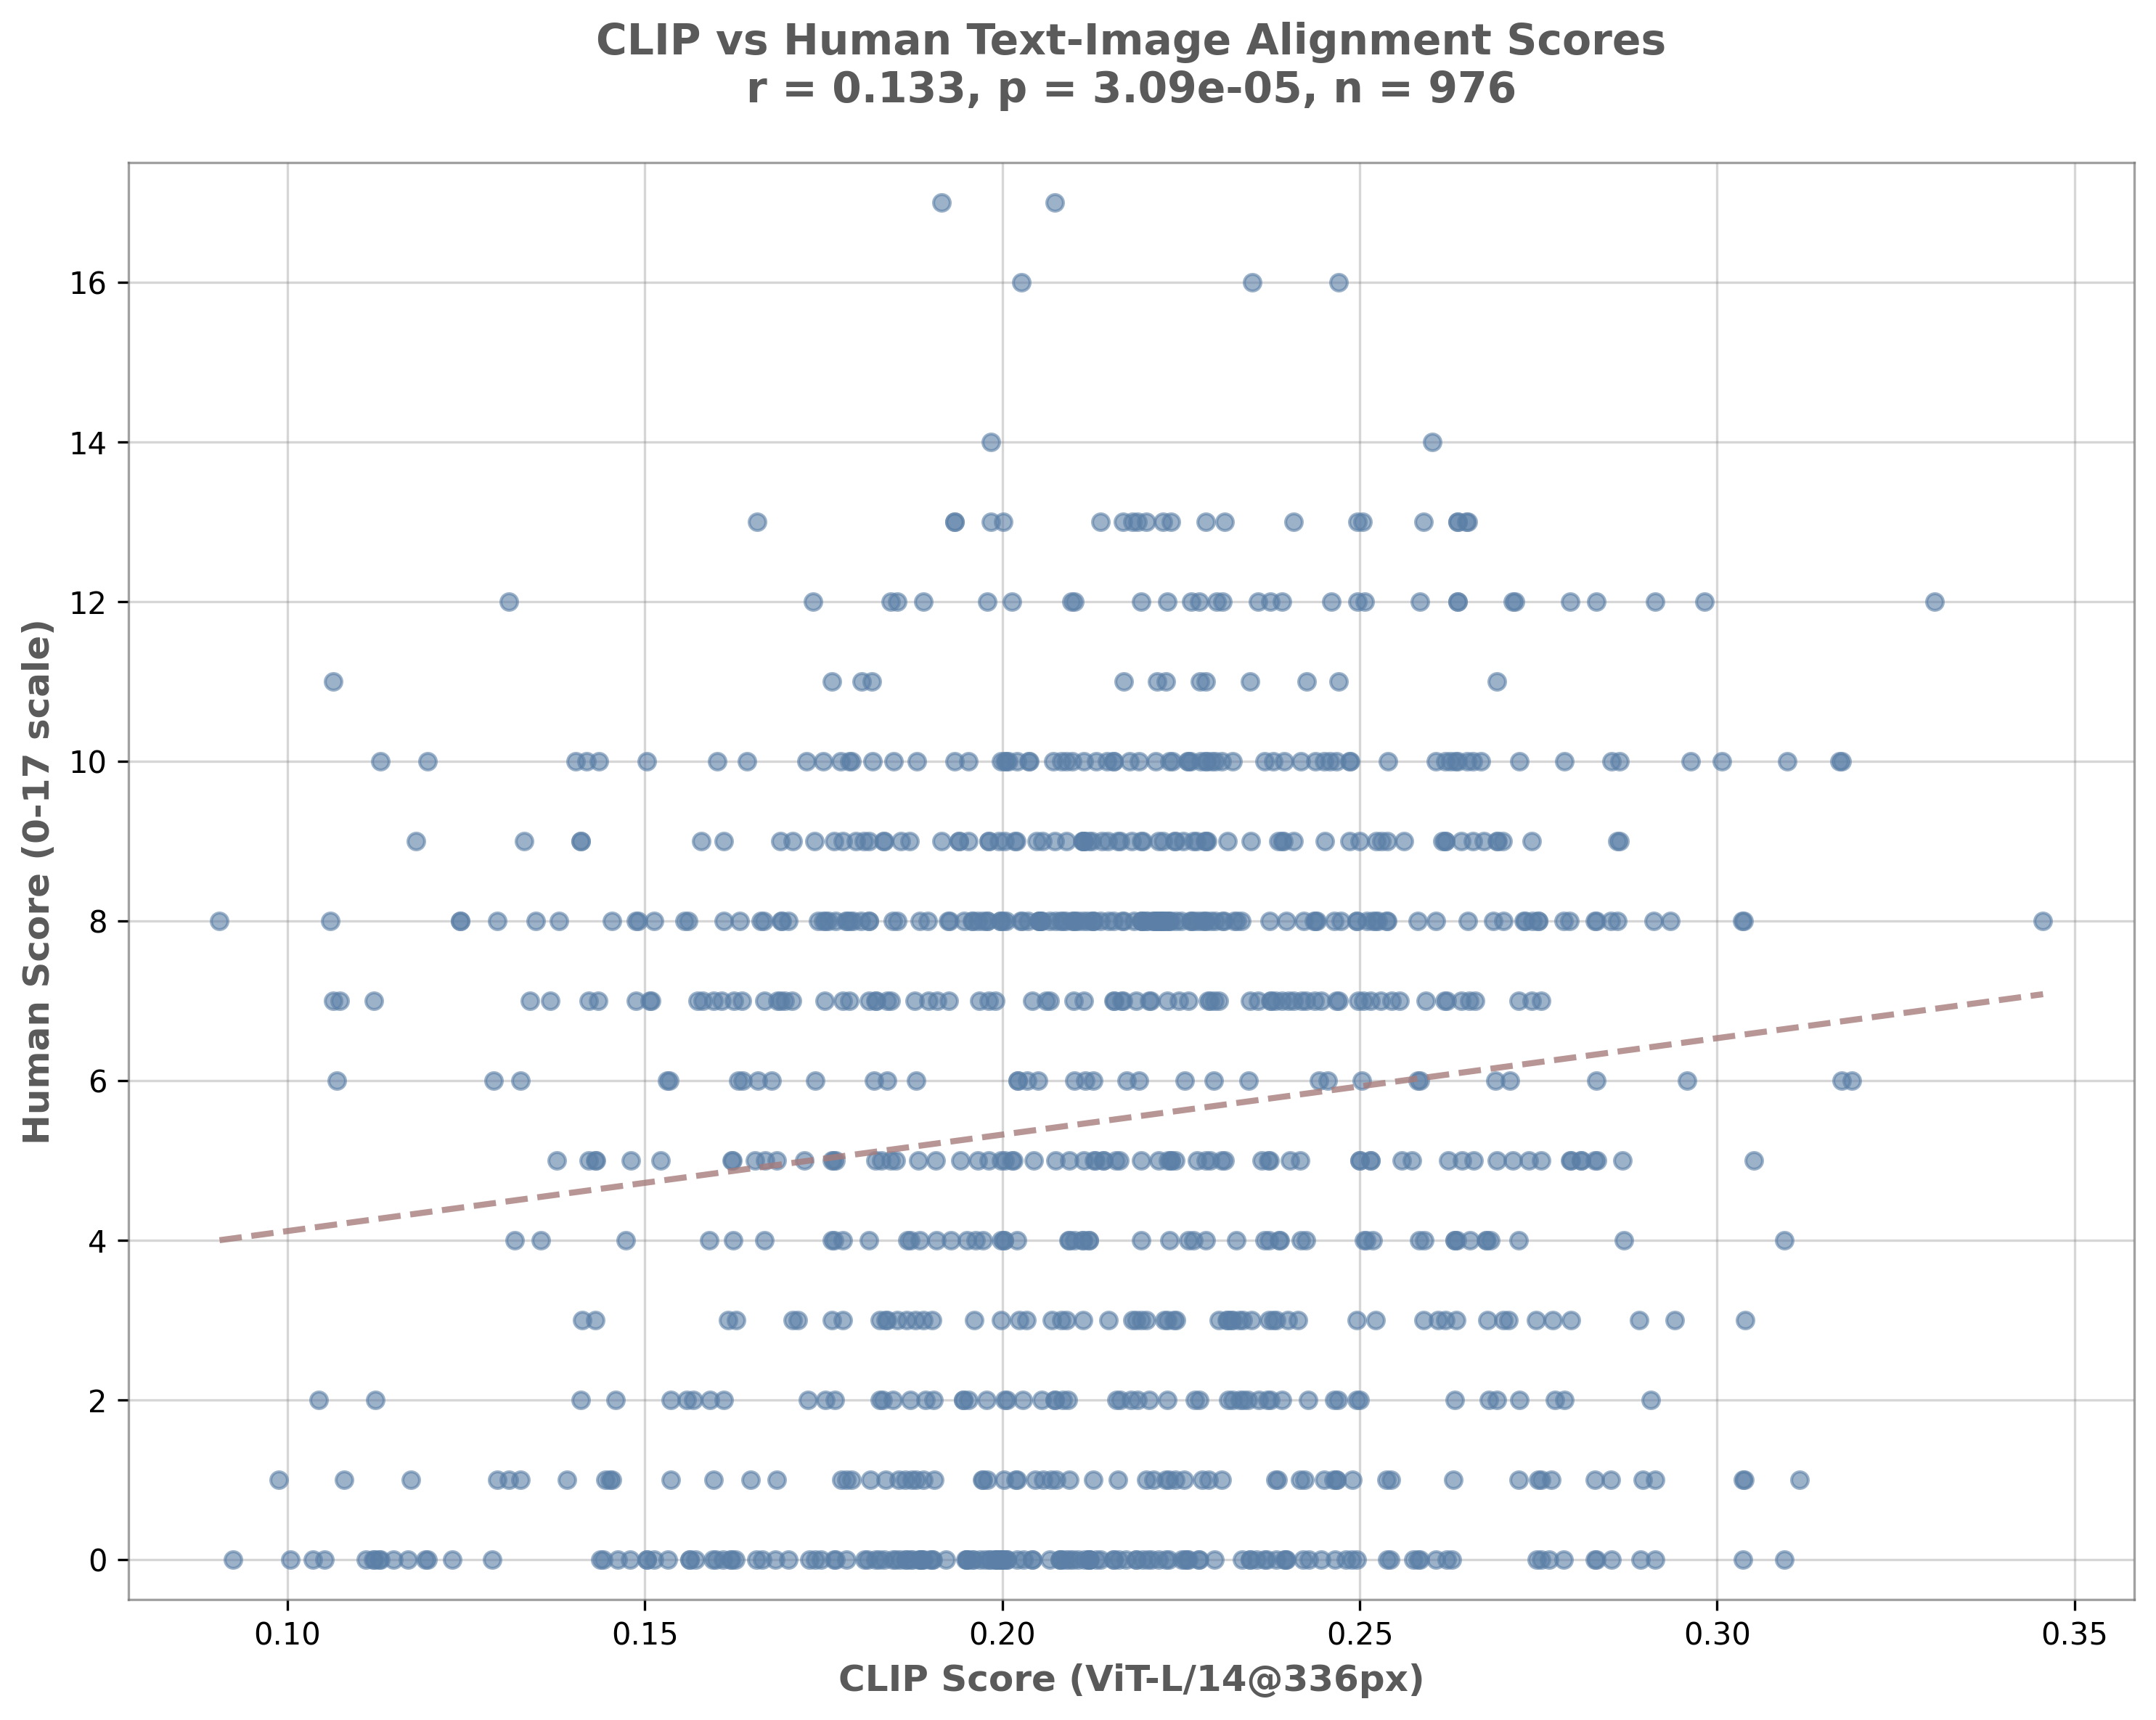


👥 Creating per-expert scatter plots...


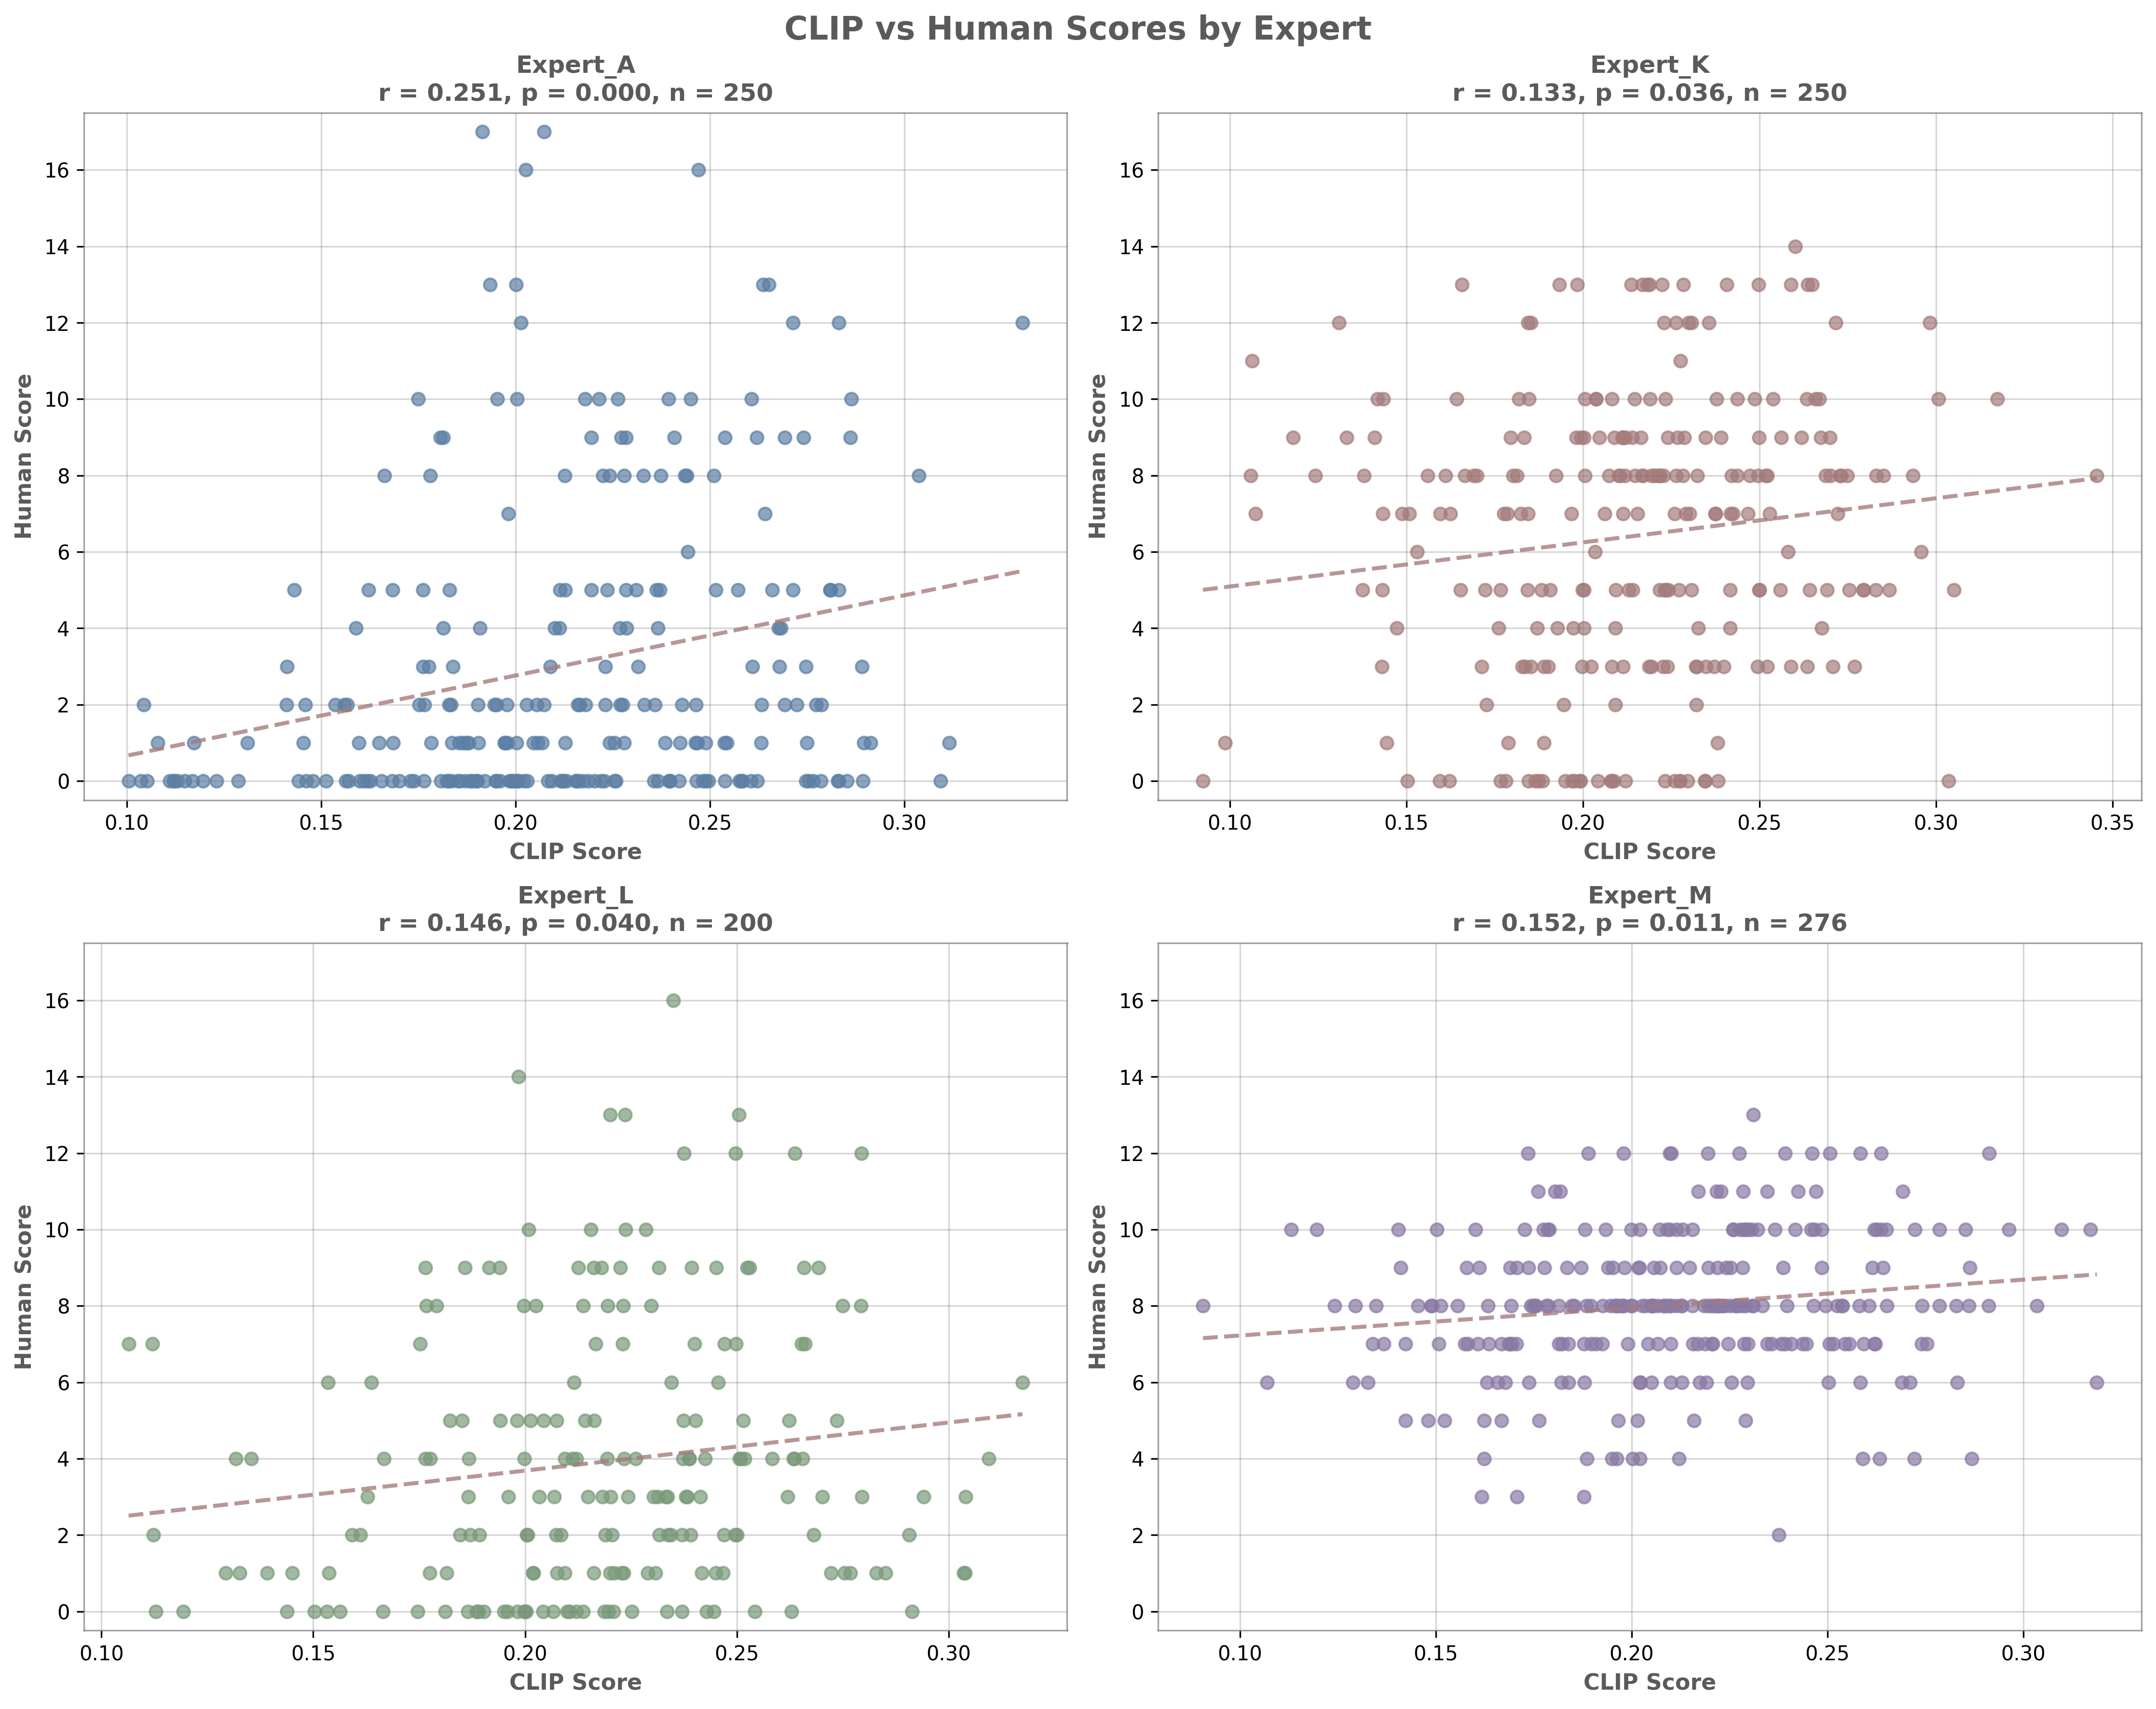


🎨 Creating per-style correlation plot...


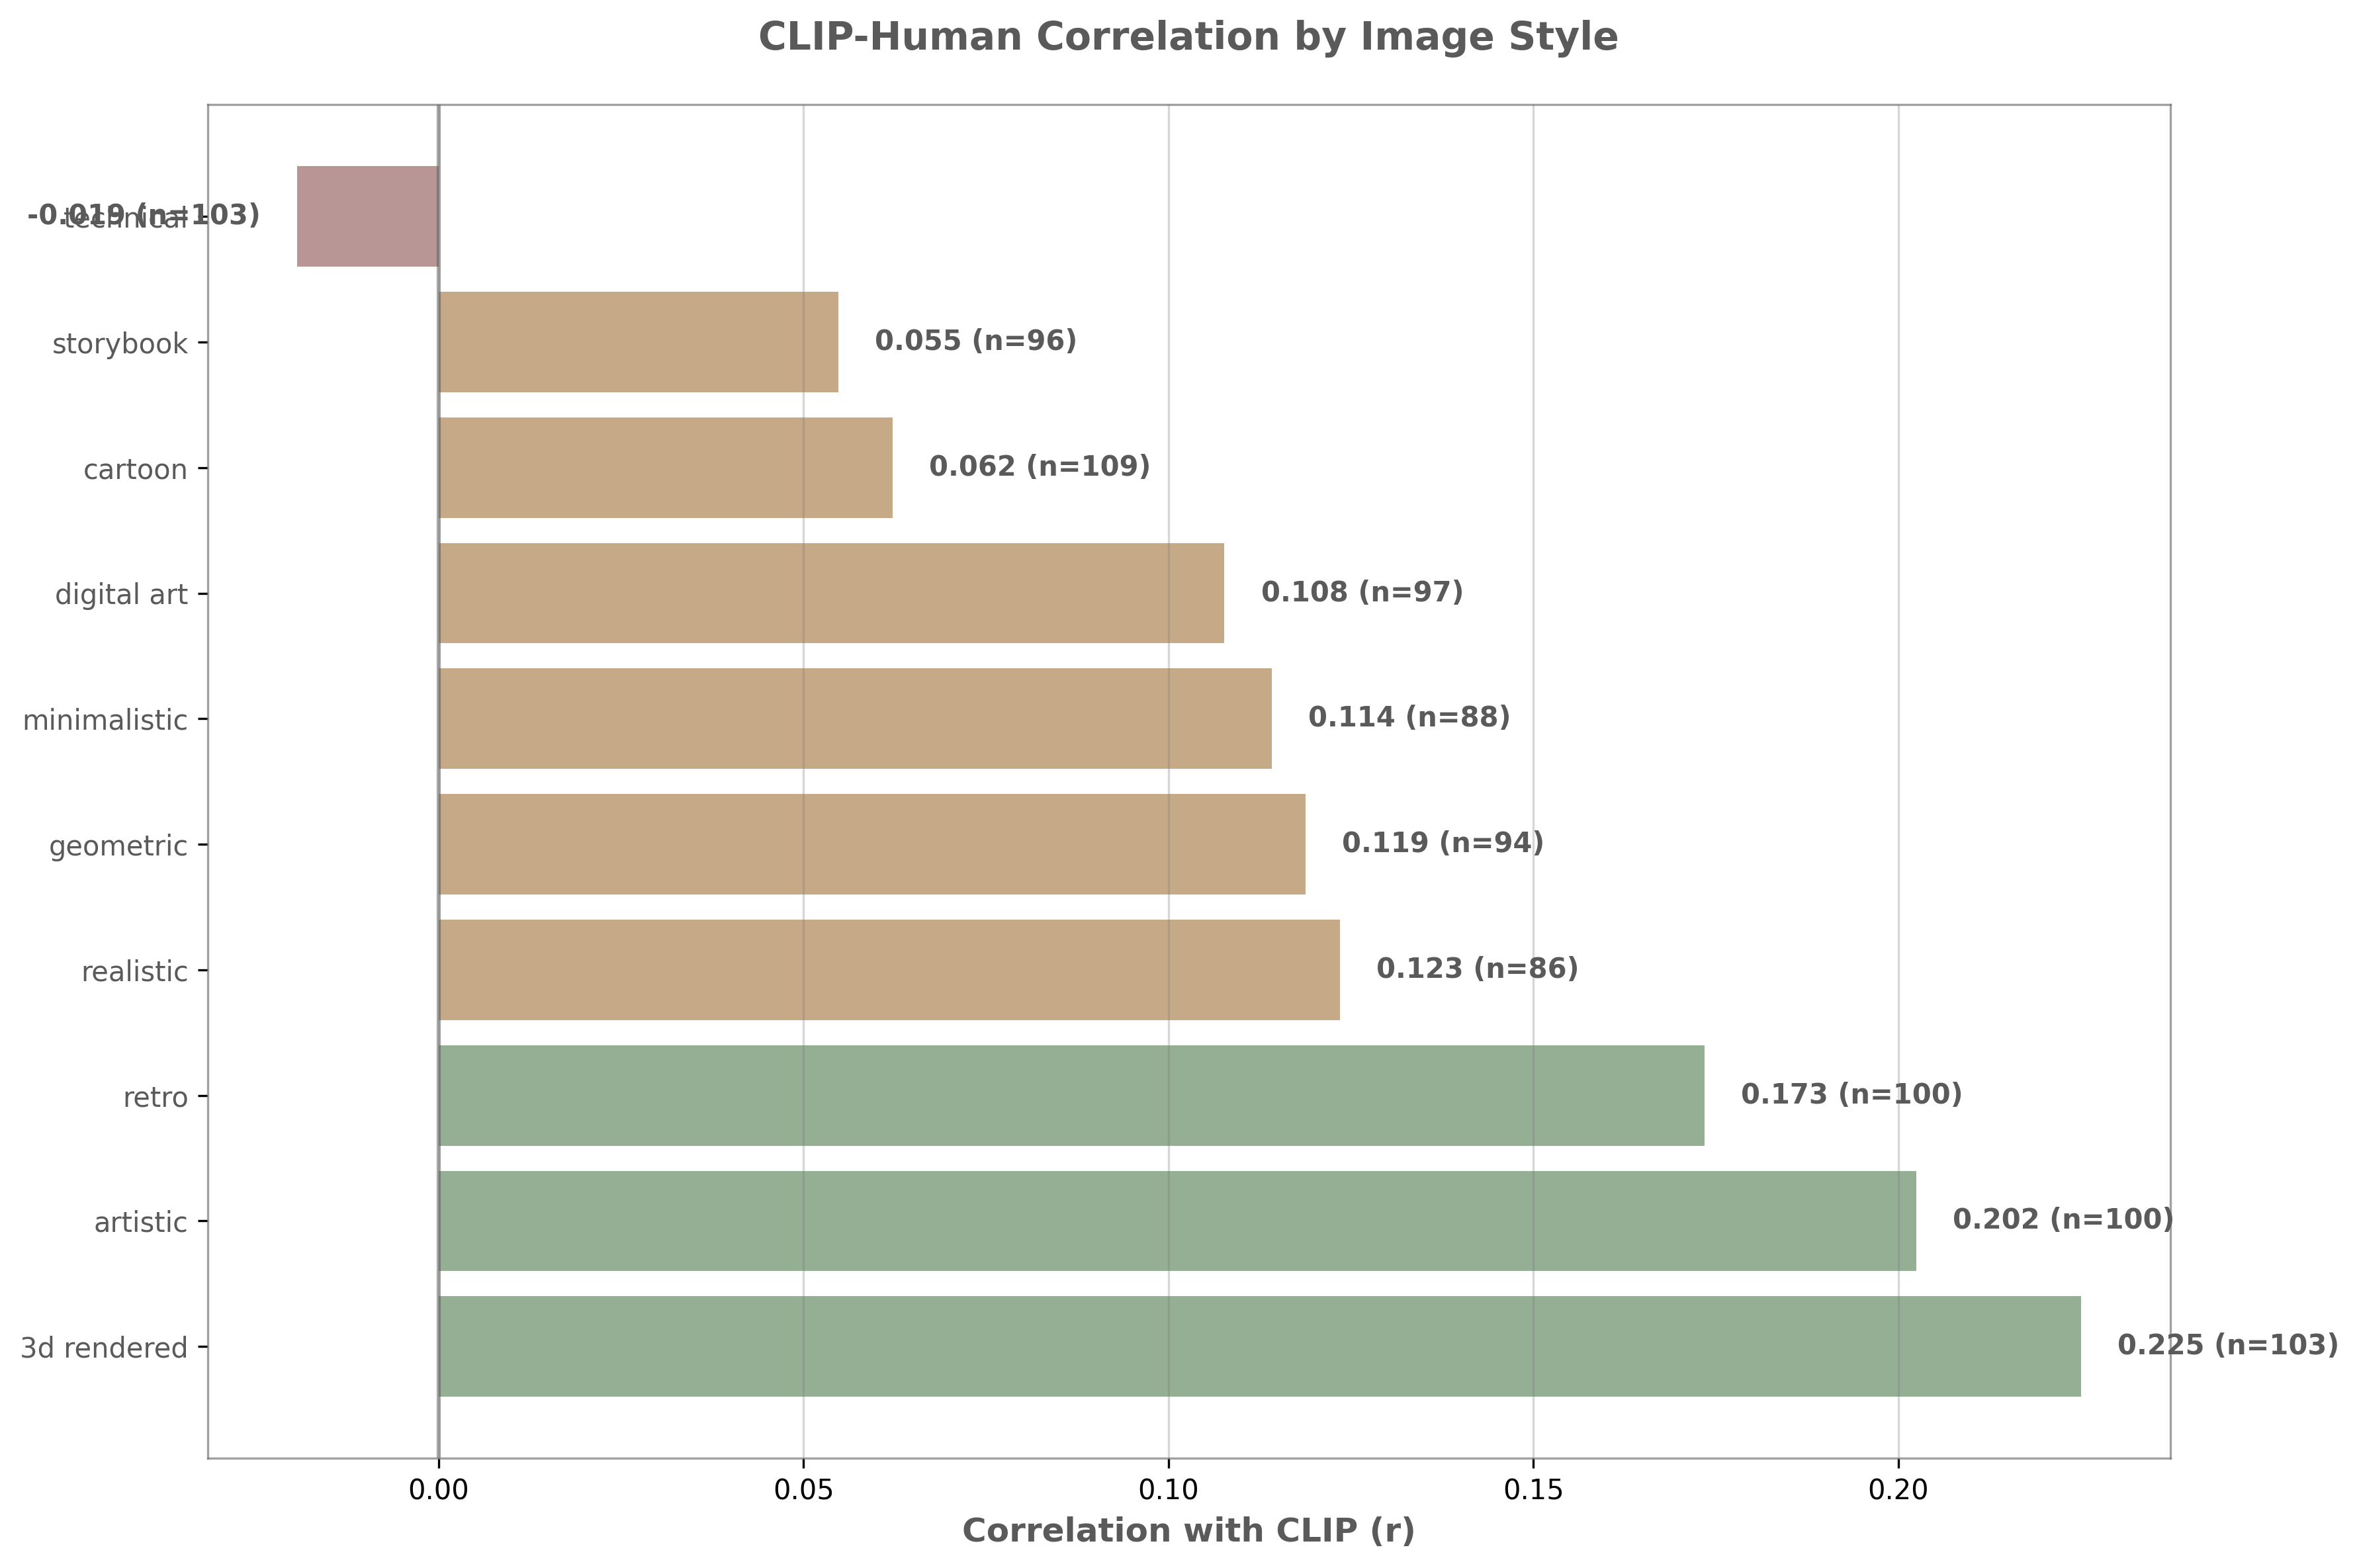


📋 Creating summary tables...

🏆 EXPERT CORRELATION SUMMARY:
  Expert  Correlation (r)  P-value  Sample Size Significance
Expert_A            0.251   0.0001          250          ***
Expert_M            0.152   0.0112          276            *
Expert_L            0.146   0.0396          200            *
Expert_K            0.133   0.0362          250            *

🎨 STYLE CORRELATION SUMMARY (Top 5 & Bottom 3):
      Style  Correlation (r)  P-value  Sample Size Significance
3d rendered            0.225   0.0223          103            *
   artistic            0.202   0.0434          100            *
      retro            0.173   0.0844          100             
  realistic            0.123   0.2573           86             
  geometric            0.119   0.2541           94             
    cartoon            0.062   0.5203          109             
  storybook            0.055   0.5958           96             
  technical           -0.019   0.8459          103             

📚 DATASE

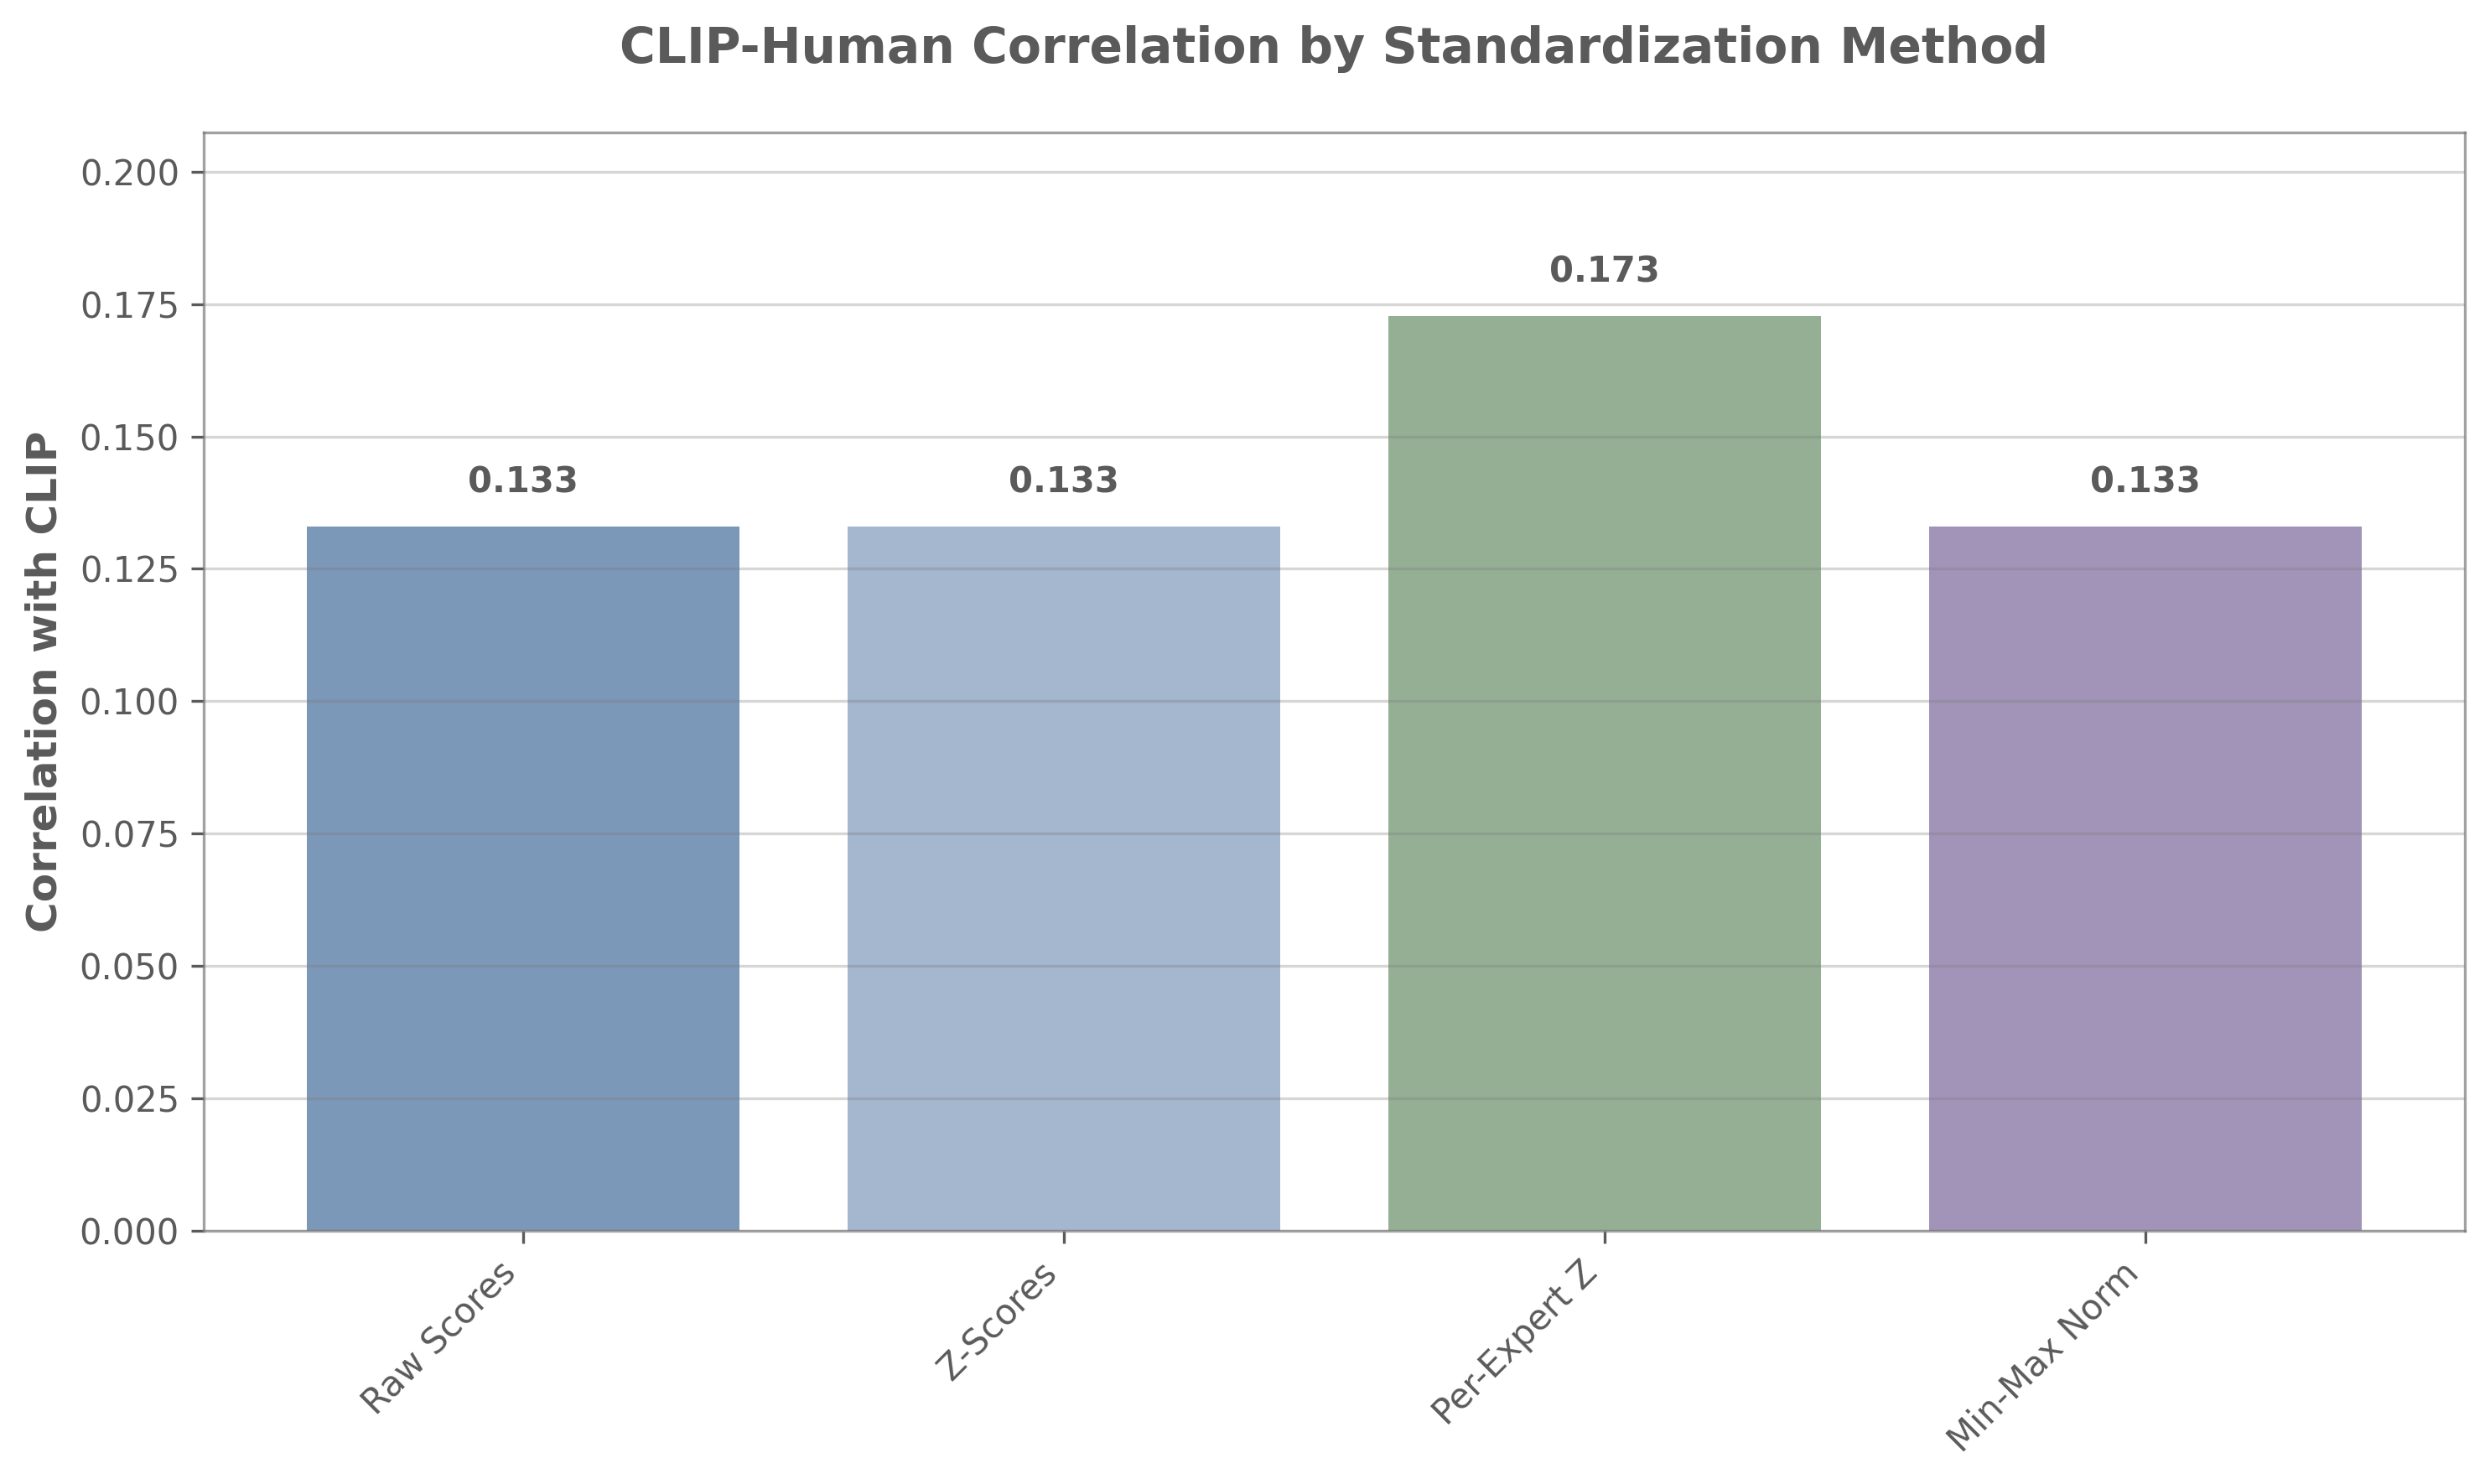


✅ STEP 5 COMPLETE!
📊 Generated visualizations:
  - clip_human_overall_scatter.png
  - clip_human_expert_scatter.png
  - clip_human_style_correlations.png
  - clip_human_standardization_comparison.png
📋 Generated summary tables:
  - summary_expert_correlations.csv
  - summary_style_correlations.csv
  - summary_dataset_correlations.csv


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Custom color palette - muted, professional colors
colors = {
    'primary_blue': '#5B7FA6',
    'primary_red': '#A67C7C', 
    'gray': '#7A7A7A',
    'light_blue': '#8FA4C4',
    'light_red': '#C49A9A',
    'dark_gray': '#5A5A5A',
    'accent_green': '#7A9B7A',
    'accent_orange': '#B8956B',
    'muted_purple': '#8B7AA6',
    'muted_teal': '#6B9B9B'
}

# Set style for clean plots  
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def step5_load_data():
    """Load the standardized scores data"""
    print("="*60)
    print("STEP 5: CLIP-HUMAN CORRELATION VISUALIZATIONS")
    print("="*60)
    
    try:
        df = pd.read_csv('step4_standardized_scores.csv')
        summary_df = pd.read_csv('step4_correlation_summary.csv')
        print(f"✓ Data loaded: {len(df)} pairs, {len(summary_df)} correlation results")
        return df, summary_df
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None, None

def step5_create_overall_scatter(df):
    """Create main scatter plot: CLIP vs Human scores"""
    print("\n📊 Creating overall scatter plot...")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Main scatter plot with primary blue
    ax.scatter(df['clip_score'], df['human_score'], alpha=0.6, s=30, color=colors['primary_blue'])
    
    # Add trend line in primary red
    z = np.polyfit(df['clip_score'], df['human_score'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df['clip_score'].min(), df['clip_score'].max(), 100)
    ax.plot(x_trend, p(x_trend), color=colors['primary_red'], linestyle='--', alpha=0.8, linewidth=2)
    
    # Calculate correlation
    r, p_val = pearsonr(df['clip_score'], df['human_score'])
    
    # Labels and title
    ax.set_xlabel('CLIP Score (ViT-L/14@336px)', fontsize=12, fontweight='bold', color=colors['dark_gray'])
    ax.set_ylabel('Human Score (0-17 scale)', fontsize=12, fontweight='bold', color=colors['dark_gray'])
    ax.set_title(f'CLIP vs Human Text-Image Alignment Scores\nr = {r:.3f}, p = {p_val:.2e}, n = {len(df)}', 
                 fontsize=14, fontweight='bold', pad=20, color=colors['dark_gray'])
    
    # Add grid
    ax.grid(True, alpha=0.3, color=colors['gray'])
    ax.set_axisbelow(True)
    
    # Set reasonable limits
    ax.set_ylim(-0.5, 17.5)
    
    # Style spines
    for spine in ax.spines.values():
        spine.set_color(colors['gray'])
        spine.set_alpha(0.7)
    
    plt.tight_layout()
    plt.savefig('clip_human_overall_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return r, p_val

def step5_create_expert_plots(df):
    """Create per-expert scatter plots"""
    print("\n👥 Creating per-expert scatter plots...")
    
    experts = sorted(df['expert'].unique())
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    expert_results = {}
    # Use muted colors for experts
    expert_colors = [colors['primary_blue'], colors['primary_red'], colors['accent_green'], colors['muted_purple']]
    
    for i, expert in enumerate(experts):
        expert_data = df[df['expert'] == expert]
        
        # Scatter plot
        axes[i].scatter(expert_data['clip_score'], expert_data['human_score'], 
                       alpha=0.7, s=40, color=expert_colors[i])
        
        # Trend line
        z = np.polyfit(expert_data['clip_score'], expert_data['human_score'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(expert_data['clip_score'].min(), expert_data['clip_score'].max(), 100)
        axes[i].plot(x_trend, p(x_trend), color=colors['primary_red'], linestyle='--', alpha=0.8, linewidth=2)
        
        # Calculate correlation
        r, p_val = pearsonr(expert_data['clip_score'], expert_data['human_score'])
        expert_results[expert] = {'r': r, 'p': p_val, 'n': len(expert_data)}
        
        # Labels and title
        axes[i].set_xlabel('CLIP Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
        axes[i].set_ylabel('Human Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
        axes[i].set_title(f'{expert}\nr = {r:.3f}, p = {p_val:.3f}, n = {len(expert_data)}', 
                         fontsize=12, fontweight='bold', color=colors['dark_gray'])
        axes[i].grid(True, alpha=0.3, color=colors['gray'])
        axes[i].set_ylim(-0.5, 17.5)
        
        # Style spines
        for spine in axes[i].spines.values():
            spine.set_color(colors['gray'])
            spine.set_alpha(0.7)
    
    plt.suptitle('CLIP vs Human Scores by Expert', fontsize=16, fontweight='bold', y=0.98, color=colors['dark_gray'])
    plt.tight_layout()
    plt.savefig('clip_human_expert_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return expert_results

def step5_create_style_plots(df):
    """Create per-style correlation plot"""
    print("\n🎨 Creating per-style correlation plot...")
    
    # Calculate correlations for each style
    style_results = {}
    for style in df['style'].unique():
        style_data = df[df['style'] == style]
        if len(style_data) > 10:  # Only styles with sufficient data
            r, p_val = pearsonr(style_data['clip_score'], style_data['human_score'])
            style_results[style] = {'r': r, 'p': p_val, 'n': len(style_data)}
    
    # Create bar plot
    styles = list(style_results.keys())
    correlations = [style_results[style]['r'] for style in styles]
    n_samples = [style_results[style]['n'] for style in styles]
    
    # Sort by correlation strength
    sorted_data = sorted(zip(styles, correlations, n_samples), key=lambda x: x[1], reverse=True)
    styles_sorted, corr_sorted, n_sorted = zip(*sorted_data)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Color code by correlation strength using muted colors
    bar_colors = []
    for r in corr_sorted:
        if r > 0.15:
            bar_colors.append(colors['accent_green'])
        elif r > 0.05:
            bar_colors.append(colors['accent_orange'])
        else:
            bar_colors.append(colors['primary_red'])
    
    bars = ax.barh(range(len(styles_sorted)), corr_sorted, color=bar_colors, alpha=0.8)
    
    # Add correlation values and sample sizes
    for i, (r, n) in enumerate(zip(corr_sorted, n_sorted)):
        ax.text(r + 0.005 if r >= 0 else r - 0.005, i, f'{r:.3f} (n={n})', 
                va='center', ha='left' if r >= 0 else 'right', fontweight='bold', color=colors['dark_gray'])
    
    ax.set_yticks(range(len(styles_sorted)))
    ax.set_yticklabels(styles_sorted, color=colors['dark_gray'])
    ax.set_xlabel('Correlation with CLIP (r)', fontsize=12, fontweight='bold', color=colors['dark_gray'])
    ax.set_title('CLIP-Human Correlation by Image Style', fontsize=14, fontweight='bold', pad=20, color=colors['dark_gray'])
    ax.grid(True, alpha=0.3, axis='x', color=colors['gray'])
    ax.axvline(x=0, color=colors['dark_gray'], linestyle='-', alpha=0.5)
    
    # Style spines
    for spine in ax.spines.values():
        spine.set_color(colors['gray'])
        spine.set_alpha(0.7)
    
    plt.tight_layout()
    plt.savefig('clip_human_style_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return style_results

def step5_create_summary_tables():
    """Create clean summary tables"""
    print("\n📋 Creating summary tables...")
    
    # Load correlation summary
    summary_df = pd.read_csv('step4_correlation_summary.csv')
    
    # Expert summary table
    expert_data = summary_df[summary_df['analysis_type'] == 'expert'].copy()
    expert_table = expert_data[['category', 'correlation', 'p_value', 'count']].copy()
    expert_table.columns = ['Expert', 'Correlation (r)', 'P-value', 'Sample Size']
    expert_table['Significance'] = expert_table['P-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    )
    expert_table = expert_table.sort_values('Correlation (r)', ascending=False)
    expert_table['Correlation (r)'] = expert_table['Correlation (r)'].round(3)
    expert_table['P-value'] = expert_table['P-value'].round(4)
    
    # Style summary table (top 5 and bottom 5)
    style_data = summary_df[summary_df['analysis_type'] == 'style'].copy()
    style_table = style_data[['category', 'correlation', 'p_value', 'count']].copy()
    style_table.columns = ['Style', 'Correlation (r)', 'P-value', 'Sample Size']
    style_table['Significance'] = style_table['P-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    )
    style_table = style_table.sort_values('Correlation (r)', ascending=False)
    style_table['Correlation (r)'] = style_table['Correlation (r)'].round(3)
    style_table['P-value'] = style_table['P-value'].round(4)
    
    # Dataset summary table
    dataset_data = summary_df[summary_df['analysis_type'] == 'dataset'].copy()
    dataset_table = dataset_data[['category', 'correlation', 'p_value', 'count']].copy()
    dataset_table.columns = ['Dataset', 'Correlation (r)', 'P-value', 'Sample Size']
    dataset_table['Significance'] = dataset_table['P-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    )
    dataset_table = dataset_table.sort_values('Correlation (r)', ascending=False)
    dataset_table['Correlation (r)'] = dataset_table['Correlation (r)'].round(3)
    dataset_table['P-value'] = dataset_table['P-value'].round(4)
    
    # Save tables
    expert_table.to_csv('summary_expert_correlations.csv', index=False)
    style_table.to_csv('summary_style_correlations.csv', index=False)
    dataset_table.to_csv('summary_dataset_correlations.csv', index=False)
    
    # Display tables
    print("\n🏆 EXPERT CORRELATION SUMMARY:")
    print("="*60)
    print(expert_table.to_string(index=False))
    
    print(f"\n🎨 STYLE CORRELATION SUMMARY (Top 5 & Bottom 3):")
    print("="*60)
    top_bottom_styles = pd.concat([style_table.head(5), style_table.tail(3)])
    print(top_bottom_styles.to_string(index=False))
    
    print(f"\n📚 DATASET CORRELATION SUMMARY:")
    print("="*60)
    print(dataset_table.to_string(index=False))
    
    return expert_table, style_table, dataset_table

def step5_create_correlation_heatmap(df):
    """Create correlation heatmap for different standardization methods"""
    print("\n🔥 Creating correlation heatmap...")
    
    # Prepare correlation matrix
    methods = ['human_score', 'human_z', 'human_expert_z', 'human_minmax']
    method_names = ['Raw Scores', 'Z-Scores', 'Per-Expert Z', 'Min-Max Norm']
    
    correlations = []
    for method in methods:
        if method in df.columns:
            r, _ = pearsonr(df[method], df['clip_score'])
            correlations.append(r)
        else:
            correlations.append(np.nan)
    
    # Create simple correlation comparison
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Use consistent color palette
    bar_colors = [colors['primary_blue'], colors['light_blue'], colors['accent_green'], colors['muted_purple']]
    
    bars = ax.bar(method_names, correlations, color=bar_colors, alpha=0.8)
    
    # Add correlation values on bars
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{corr:.3f}', ha='center', va='bottom', fontweight='bold', color=colors['dark_gray'])
    
    ax.set_ylabel('Correlation with CLIP', fontsize=12, fontweight='bold', color=colors['dark_gray'])
    ax.set_title('CLIP-Human Correlation by Standardization Method', fontsize=14, fontweight='bold', pad=20, color=colors['dark_gray'])
    ax.grid(True, alpha=0.3, axis='y', color=colors['gray'])
    ax.set_ylim(0, max(correlations) * 1.2)
    
    # Style spines and labels
    for spine in ax.spines.values():
        spine.set_color(colors['gray'])
        spine.set_alpha(0.7)
    
    ax.tick_params(colors=colors['dark_gray'])
    plt.xticks(rotation=45, ha='right', color=colors['dark_gray'])
    plt.tight_layout()
    plt.savefig('clip_human_standardization_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_step5():
    """Run complete Step 5: Visualizations and Summary"""
    print("STEP 5: CLIP-HUMAN CORRELATION VISUALIZATIONS & SUMMARY")
    print("="*60)
    
    # Load data
    df, summary_df = step5_load_data()
    if df is None:
        return None
    
    # Create visualizations
    overall_r, overall_p = step5_create_overall_scatter(df)
    expert_results = step5_create_expert_plots(df)
    style_results = step5_create_style_plots(df)
    
    # Create summary tables
    expert_table, style_table, dataset_table = step5_create_summary_tables()
    
    # Create standardization comparison
    step5_create_correlation_heatmap(df)
    
    print(f"\n✅ STEP 5 COMPLETE!")
    print(f"📊 Generated visualizations:")
    print(f"  - clip_human_overall_scatter.png")
    print(f"  - clip_human_expert_scatter.png") 
    print(f"  - clip_human_style_correlations.png")
    print(f"  - clip_human_standardization_comparison.png")
    print(f"📋 Generated summary tables:")
    print(f"  - summary_expert_correlations.csv")
    print(f"  - summary_style_correlations.csv")
    print(f"  - summary_dataset_correlations.csv")
    
    return df, expert_table, style_table, dataset_table

if __name__ == "__main__":
    results = run_step5()

# Step 6: TIFA Score Calculation and Correlation Analysis

In [3]:
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



import sys
import os

# Dynamically compute the parent folder path of your current script
current_dir = os.getcwd()
tifa_path = os.path.abspath(os.path.join(current_dir, '..', 'tifa'))

# Add tifa path to sys.path
sys.path.append(tifa_path)

# Now you can safely import
from tifascore import VQAModel, get_question_and_answers, UnifiedQAModel, filter_question_and_answers, tifa_score_single

# Custom color palette - consistent with previous visualizations
colors = {
    'primary_blue': '#5B7FA6',
    'primary_red': '#A67C7C', 
    'gray': '#7A7A7A',
    'light_blue': '#8FA4C4',
    'light_red': '#C49A9A',
    'dark_gray': '#5A5A5A',
    'accent_green': '#7A9B7A',
    'accent_orange': '#B8956B',
    'muted_purple': '#8B7AA6',
    'muted_teal': '#6B9B9B'
}

# Set DPI for high-quality plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# File paths
CLIP_HUMAN_SCORES_FILE = 'step4_standardized_scores.csv'
IMAGE_DIR = r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\phase3_label_studio\2000_set_shuffled'

def step6_load_previous_data():
    """Step 6A: Load CLIP and human scores from previous analysis"""
    print("="*60)
    print("STEP 6A: LOADING PREVIOUS CLIP AND HUMAN SCORES")
    print("="*60)
    
    try:
        df = pd.read_csv(CLIP_HUMAN_SCORES_FILE)
        print(f"✓ Data loaded successfully")
        print(f"📊 Total records: {len(df)}")
        print(f"📋 Available scores: human_score, clip_score")
        
        # Check data completeness
        missing_clip = df['clip_score'].isnull().sum()
        missing_human = df['human_score'].isnull().sum()
        
        print(f"\n🔍 Data completeness:")
        print(f"Missing CLIP scores: {missing_clip}")
        print(f"Missing human scores: {missing_human}")
        print(f"Complete pairs available: {len(df) - max(missing_clip, missing_human)}")
        
        return df
        
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None

def step6_setup_tifa():
    """Step 6B: Setup TIFA models and dependencies"""
    print("\n" + "="*60)
    print("STEP 6B: SETTING UP TIFA MODELS")
    print("="*60)
    
    try:
        # Try importing TIFA components - check multiple possible module names
        tifa_imported = False
        
        # Try different import paths
        try:
            from tifascore import VQAModel, get_question_and_answers, UnifiedQAModel, filter_question_and_answers, tifa_score_single
            tifa_imported = True
            print("✓ TIFA imported from tifascore")
        except ImportError:
            try:
                import sys
                sys.path.append('./tifa')  # Add local tifa directory to path
                from tifascore import VQAModel, get_question_and_answers, UnifiedQAModel, filter_question_and_answers, tifa_score_single
                tifa_imported = True
                print("✓ TIFA imported from local ./tifa directory")
            except ImportError:
                try:
                    # Try importing from tifa module directly
                    from tifa.tifascore import VQAModel, get_question_and_answers, UnifiedQAModel, filter_question_and_answers, tifa_score_single
                    tifa_imported = True
                    print("✓ TIFA imported from tifa.tifascore")
                except ImportError:
                    pass
        
        if not tifa_imported:
            print("✗ TIFA not found. Please install using:")
            print("  1. git clone https://github.com/Yushi-Hu/tifa.git")
            print("  2. cd tifa")
            print("  3. pip install -r requirements.txt")
            print("  4. pip install -e .")
            print("\nAlternatively, ensure the tifa directory is in your current working directory.")
            return None, None
        
        print("Loading TIFA models...")
        print("  - Loading VQA model (mplug-large)...")
        vqa_model = VQAModel("mplug-large")
        
        print("  - Loading UnifiedQA model for question filtering...")
        unifiedqa_model = UnifiedQAModel("allenai/unifiedqa-v2-t5-large-1363200")
        
        print("✓ TIFA models loaded successfully")
        
        return vqa_model, unifiedqa_model
        
    except Exception as e:
        print(f"✗ Error setting up TIFA: {e}")
        print("\nTroubleshooting steps:")
        print("1. Ensure you've cloned the TIFA repository:")
        print("   git clone https://github.com/Yushi-Hu/tifa.git")
        print("2. Navigate to the tifa directory and install:")
        print("   cd tifa")
        print("   pip install -r requirements.txt")
        print("   pip install -e .")
        print("3. Run this script from the same directory as the tifa folder")
        return None, None

def step6_generate_questions_sample(df, num_samples=10):
    """Step 6C: Generate TIFA questions for a sample of texts"""
    print("\n" + "="*60)
    print("STEP 6C: GENERATING TIFA QUESTIONS (SAMPLE)")
    print("="*60)
    
    # Use LLaMA 2 for question generation (no OpenAI API needed)
    try:
        # Try different import paths for LLaMA 2 functions
        try:
            from tifascore import get_llama2_pipeline, get_llama2_question_and_answers
        except ImportError:
            import sys
            sys.path.append(r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\tifa")
            from tifascore import get_llama2_pipeline, get_llama2_question_and_answers
        
        print("Loading LLaMA 2 question generation pipeline...")
        pipeline = get_llama2_pipeline("tifa-benchmark/llama2_tifa_question_generation")
        
        # Sample a subset for testing
        sample_df = df.head(num_samples).copy()
        print(f"Generating questions for {len(sample_df)} sample texts...")
        
        questions_data = {}
        
        for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Generating questions"):
            text = row['simplified_text']
            
            # Generate questions using LLaMA 2
            questions = get_llama2_question_and_answers(pipeline, text)
            
            # Store with a unique key
            key = f"sample_{idx}"
            questions_data[key] = {
                'text': text,
                'questions': questions,
                'image_path': row['image_path'],
                'human_score': row['human_score'],
                'clip_score': row['clip_score']
            }
            
            print(f"  Generated {len(questions)} questions for: {text[:50]}...")
        
        # Save questions for reuse
        with open('step6_sample_questions.json', 'w') as f:
            json.dump(questions_data, f, indent=2)
        
        print(f"✓ Questions generated and saved to step6_sample_questions.json")
        return questions_data
        
    except Exception as e:
        print(f"✗ Error generating questions: {e}")
        print("This might be due to TIFA installation issues or model loading problems.")
        return None

def step6_calculate_tifa_scores(vqa_model, unifiedqa_model, questions_data):
    """Step 6D: Calculate TIFA scores for the sample"""
    print("\n" + "="*60)
    print("STEP 6D: CALCULATING TIFA SCORES")
    print("="*60)
    
    try:
        # Try different import paths
        try:
            from tifascore import filter_question_and_answers, tifa_score_single
        except ImportError:
            import sys
            sys.path.append('./tifa')
            from tifascore import filter_question_and_answers, tifa_score_single
    except ImportError as e:
        print(f"✗ Cannot import TIFA scoring functions: {e}")
        return []
    
    tifa_results = []
    successful_calculations = 0
    failed_calculations = []
    
    print(f"Calculating TIFA scores for {len(questions_data)} samples...")
    
    for key, data in tqdm(questions_data.items(), desc="Computing TIFA scores"):
        try:
            # Filter questions with UnifiedQA
            filtered_questions = filter_question_and_answers(unifiedqa_model, data['questions'])
            
            if len(filtered_questions) == 0:
                print(f"  ⚠️ No questions passed filtering for {key}")
                failed_calculations.append((key, "No questions passed filtering"))
                continue
            
            # Calculate TIFA score
            result = tifa_score_single(vqa_model, filtered_questions, data['image_path'])
            
            tifa_results.append({
                'key': key,
                'text': data['text'],
                'image_path': data['image_path'],
                'human_score': data['human_score'],
                'clip_score': data['clip_score'],
                'tifa_score': result['tifa_score'],
                'num_questions': len(filtered_questions),
                'question_details': result
            })
            
            successful_calculations += 1
            print(f"  ✓ {key}: TIFA = {result['tifa_score']:.3f} ({len(filtered_questions)} questions)")
            
        except Exception as e:
            failed_calculations.append((key, str(e)))
            print(f"  ✗ {key}: Error - {e}")
    
    print(f"\n📊 TIFA CALCULATION SUMMARY:")
    print(f"Successful: {successful_calculations}/{len(questions_data)}")
    print(f"Failed: {len(failed_calculations)}/{len(questions_data)}")
    
    if failed_calculations:
        print(f"\n⚠️ Failed calculations:")
        for key, error in failed_calculations[:5]:  # Show first 5
            print(f"  {key}: {error}")
    
    return tifa_results

def step6_correlation_analysis(tifa_results):
    """Step 6E: Analyze correlations between TIFA, CLIP, and human scores"""
    print("\n" + "="*60)
    print("STEP 6E: CORRELATION ANALYSIS - TIFA vs CLIP vs HUMAN")
    print("="*60)
    
    # Convert to DataFrame
    df_tifa = pd.DataFrame(tifa_results)
    
    if len(df_tifa) == 0:
        print("✗ No TIFA results available for correlation analysis")
        return None
    
    # Calculate correlations
    print("📊 CORRELATION RESULTS:")
    print("="*50)
    
    correlations = {}
    
    # TIFA vs Human
    r_th, p_th = pearsonr(df_tifa['tifa_score'], df_tifa['human_score'])
    correlations['tifa_human'] = {'r': r_th, 'p': p_th}
    print(f"TIFA vs Human:     r = {r_th:6.4f}, p = {p_th:8.6f}")
    
    # TIFA vs CLIP
    r_tc, p_tc = pearsonr(df_tifa['tifa_score'], df_tifa['clip_score'])
    correlations['tifa_clip'] = {'r': r_tc, 'p': p_tc}
    print(f"TIFA vs CLIP:      r = {r_tc:6.4f}, p = {p_tc:8.6f}")
    
    # CLIP vs Human (for comparison)
    r_ch, p_ch = pearsonr(df_tifa['clip_score'], df_tifa['human_score'])
    correlations['clip_human'] = {'r': r_ch, 'p': p_ch}
    print(f"CLIP vs Human:     r = {r_ch:6.4f}, p = {p_ch:8.6f}")
    
    # Score statistics
    print(f"\n📈 SCORE STATISTICS:")
    print(f"TIFA scores:  mean = {df_tifa['tifa_score'].mean():.3f}, std = {df_tifa['tifa_score'].std():.3f}")
    print(f"CLIP scores:  mean = {df_tifa['clip_score'].mean():.3f}, std = {df_tifa['clip_score'].std():.3f}")
    print(f"Human scores: mean = {df_tifa['human_score'].mean():.3f}, std = {df_tifa['human_score'].std():.3f}")
    
    return df_tifa, correlations

def step6_create_visualizations(df_tifa, correlations):
    """Step 6F: Create correlation visualizations"""
    print("\n" + "="*60)
    print("STEP 6F: CREATING CORRELATION VISUALIZATIONS")
    print("="*60)
    
    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: TIFA vs Human
    axes[0,0].scatter(df_tifa['tifa_score'], df_tifa['human_score'], 
                     alpha=0.7, s=60, color=colors['primary_blue'])
    
    # Trend line
    z = np.polyfit(df_tifa['tifa_score'], df_tifa['human_score'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_tifa['tifa_score'].min(), df_tifa['tifa_score'].max(), 100)
    axes[0,0].plot(x_trend, p(x_trend), color=colors['primary_red'], linestyle='--', alpha=0.8, linewidth=2)
    
    r_th = correlations['tifa_human']['r']
    p_th = correlations['tifa_human']['p']
    axes[0,0].set_xlabel('TIFA Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[0,0].set_ylabel('Human Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[0,0].set_title(f'TIFA vs Human Scores\nr = {r_th:.3f}, p = {p_th:.3f}, n = {len(df_tifa)}', 
                       fontsize=12, fontweight='bold', color=colors['dark_gray'])
    axes[0,0].grid(True, alpha=0.3, color=colors['gray'])
    
    # Plot 2: TIFA vs CLIP
    axes[0,1].scatter(df_tifa['tifa_score'], df_tifa['clip_score'], 
                     alpha=0.7, s=60, color=colors['accent_green'])
    
    z = np.polyfit(df_tifa['tifa_score'], df_tifa['clip_score'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_tifa['tifa_score'].min(), df_tifa['tifa_score'].max(), 100)
    axes[0,1].plot(x_trend, p(x_trend), color=colors['primary_red'], linestyle='--', alpha=0.8, linewidth=2)
    
    r_tc = correlations['tifa_clip']['r']
    p_tc = correlations['tifa_clip']['p']
    axes[0,1].set_xlabel('TIFA Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[0,1].set_ylabel('CLIP Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[0,1].set_title(f'TIFA vs CLIP Scores\nr = {r_tc:.3f}, p = {p_tc:.3f}, n = {len(df_tifa)}', 
                       fontsize=12, fontweight='bold', color=colors['dark_gray'])
    axes[0,1].grid(True, alpha=0.3, color=colors['gray'])
    
    # Plot 3: CLIP vs Human (for reference)
    axes[1,0].scatter(df_tifa['clip_score'], df_tifa['human_score'], 
                     alpha=0.7, s=60, color=colors['muted_purple'])
    
    z = np.polyfit(df_tifa['clip_score'], df_tifa['human_score'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_tifa['clip_score'].min(), df_tifa['clip_score'].max(), 100)
    axes[1,0].plot(x_trend, p(x_trend), color=colors['primary_red'], linestyle='--', alpha=0.8, linewidth=2)
    
    r_ch = correlations['clip_human']['r']
    p_ch = correlations['clip_human']['p']
    axes[1,0].set_xlabel('CLIP Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[1,0].set_ylabel('Human Score', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[1,0].set_title(f'CLIP vs Human Scores\nr = {r_ch:.3f}, p = {p_ch:.3f}, n = {len(df_tifa)}', 
                       fontsize=12, fontweight='bold', color=colors['dark_gray'])
    axes[1,0].grid(True, alpha=0.3, color=colors['gray'])
    
    # Plot 4: Correlation comparison bar chart
    methods = ['TIFA vs\nHuman', 'TIFA vs\nCLIP', 'CLIP vs\nHuman']
    cors = [correlations['tifa_human']['r'], correlations['tifa_clip']['r'], correlations['clip_human']['r']]
    bar_colors = [colors['primary_blue'], colors['accent_green'], colors['muted_purple']]
    
    bars = axes[1,1].bar(methods, cors, color=bar_colors, alpha=0.8)
    
    # Add correlation values on bars
    for bar, corr in zip(bars, cors):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{corr:.3f}', ha='center', va='bottom', fontweight='bold', color=colors['dark_gray'])
    
    axes[1,1].set_ylabel('Correlation (r)', fontsize=11, fontweight='bold', color=colors['dark_gray'])
    axes[1,1].set_title('Correlation Comparison', fontsize=12, fontweight='bold', color=colors['dark_gray'])
    axes[1,1].grid(True, alpha=0.3, axis='y', color=colors['gray'])
    axes[1,1].set_ylim(0, max(cors) * 1.2)
    
    # Style all subplots
    for ax in axes.flat:
        for spine in ax.spines.values():
            spine.set_color(colors['gray'])
            spine.set_alpha(0.7)
        ax.tick_params(colors=colors['dark_gray'])
    
    plt.suptitle('TIFA, CLIP, and Human Score Correlations', fontsize=16, fontweight='bold', 
                 y=0.98, color=colors['dark_gray'])
    plt.tight_layout()
    plt.savefig('step6_tifa_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Correlation visualizations saved to: step6_tifa_correlations.png")

def step6_save_results(df_tifa, correlations):
    """Step 6G: Save TIFA results and correlation summary"""
    print("\n" + "="*60)
    print("STEP 6G: SAVING TIFA RESULTS")
    print("="*60)
    
    # Save complete TIFA results
    df_tifa.to_csv('step6_tifa_results.csv', index=False)
    print("✓ TIFA results saved to: step6_tifa_results.csv")
    
    # Save correlation summary
    correlation_summary = []
    for pair, result in correlations.items():
        correlation_summary.append({
            'comparison': pair,
            'correlation': result['r'],
            'p_value': result['p'],
            'sample_size': len(df_tifa)
        })
    
    summary_df = pd.DataFrame(correlation_summary)
    summary_df.to_csv('step6_correlation_summary.csv', index=False)
    print("✓ Correlation summary saved to: step6_correlation_summary.csv")
    
    # Print final summary
    print(f"\n📊 FINAL TIFA ANALYSIS SUMMARY:")
    print(f"Sample size: {len(df_tifa)} image-text pairs")
    print(f"TIFA vs Human correlation: r = {correlations['tifa_human']['r']:.4f}")
    print(f"TIFA vs CLIP correlation: r = {correlations['tifa_clip']['r']:.4f}")
    print(f"CLIP vs Human correlation: r = {correlations['clip_human']['r']:.4f}")
    
    return summary_df

def run_step6(sample_size=50):
    """Run complete Step 6: TIFA Score Calculation and Correlation Analysis"""
    print("STEP 6: TIFA SCORE CALCULATION AND CORRELATION ANALYSIS")
    print("="*60)
    
    # Step 6A: Load previous data
    df = step6_load_previous_data()
    if df is None:
        return None
    
    # Step 6B: Setup TIFA models
    vqa_model, unifiedqa_model = step6_setup_tifa()
    if vqa_model is None:
        return None
    
    # Step 6C: Generate questions for sample
    questions_data = step6_generate_questions_sample(df, num_samples=sample_size)
    if questions_data is None:
        return None
    
    # Step 6D: Calculate TIFA scores
    tifa_results = step6_calculate_tifa_scores(vqa_model, unifiedqa_model, questions_data)
    if not tifa_results:
        return None
    
    # Step 6E: Correlation analysis
    df_tifa, correlations = step6_correlation_analysis(tifa_results)
    if df_tifa is None:
        return None
    
    # Step 6F: Create visualizations
    step6_create_visualizations(df_tifa, correlations)
    
    # Step 6G: Save results
    summary_df = step6_save_results(df_tifa, correlations)
    
    print(f"\n✅ STEP 6 COMPLETE!")
    print(f"TIFA analysis complete with {len(df_tifa)} successful evaluations")
    print(f"Files generated:")
    print(f"  - step6_tifa_results.csv (detailed TIFA results)")
    print(f"  - step6_correlation_summary.csv (correlation summary)")
    print(f"  - step6_tifa_correlations.png (correlation visualizations)")
    
    return df_tifa, correlations

if __name__ == "__main__":
    # Run with a sample of 50 pairs (adjust as needed)
    results = run_step6(sample_size=50)

ModuleNotFoundError: No module named 'tifascore'